In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
#pd.set_option('display.max_rows', 200)
pd.set_option("display.max_columns", 999)
import uproot
import os
from multiprocessing import Pool
import psutil

import tensorflow as tf
print(tf.__version__)
print(tf.test.is_built_with_cuda())

2023-12-07 15:11:00.992880: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 15:11:01.173331: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.10.0
True


In [2]:
def get_min(Ref, Array):
    return np.argmin(np.abs(Ref - Array))

In [3]:
ReadList = ["Mass", "evt_trig",
        "fourjetmasstev", "Mjj_avg_dRpairing_GeV",

        #"Mjj_msortedP1_high_div4jm", "Mjj_msortedP1_low_div4jm",
        #"Mjj_msortedP2_high_div4jm", "Mjj_msortedP2_low_div4jm",
        #"Mjj_msortedP3_high_div4jm", "Mjj_msortedP3_low_div4jm",

        "P1high_MTeV", "P1low_MTeV",
        "P2high_MTeV", "P2low_MTeV",
        "P3high_MTeV", "P3low_MTeV",

        "P1high_dR", "P1low_dR",
        "P2high_dR", "P2low_dR",
        "P3high_dR", "P3low_dR",]

In [4]:
def add_more_cols(DF):
    DF["P1high_M"] = DF["P1high_MTeV"] * 1000
    DF["P1low_M"] = DF["P1low_MTeV"] * 1000
    DF["P2high_M"] = DF["P2high_MTeV"] * 1000
    DF["P2low_M"] = DF["P2low_MTeV"] * 1000
    DF["P3high_M"] = DF["P3high_MTeV"] * 1000
    DF["P3low_M"] = DF["P3low_MTeV"] * 1000
    
    DF["P1M"] = (DF["P1high_M"] + DF["P1low_M"]) / 2
    DF["P2M"] = (DF["P2high_M"] + DF["P2low_M"]) / 2
    DF["P3M"] = (DF["P3high_M"] + DF["P3low_M"]) / 2
    
    DF["dRi"] = DF.apply(lambda row: get_min(row["Mjj_avg_dRpairing_GeV"], 
                                np.array([row["P1M"], row["P2M"], row["P3M"]])), axis = 1)
    DF["Truth_high"] = DF.apply(lambda row: get_min(row["Mass"],
                                np.array([row["P1high_M"], row["P2high_M"], row["P3high_M"]])), axis = 1)
    DF["Truth_avg"] = DF.apply(lambda row: get_min(row["Mass"], 
                                np.array([row["P1M"], row["P2M"], row["P3M"]])), axis = 1)
    
    DF["P1QSMD"] = (DF["P1high_M"] - DF["Mass"])**2 + (DF["P1low_M"] - DF["Mass"])**2
    DF["P2QSMD"] = (DF["P2high_M"] - DF["Mass"])**2 + (DF["P2low_M"] - DF["Mass"])**2
    DF["P3QSMD"] = (DF["P3high_M"] - DF["Mass"])**2 + (DF["P3low_M"] - DF["Mass"])**2
    
    DF["Truth_QSMD"] = DF.apply(lambda row: get_min(0, 
                                np.array([row["P1QSMD"], row["P2QSMD"], row["P3QSMD"]])), axis = 1)

In [5]:
def make_training_and_testing_pd(Mass):
    TrainingRows = 100000
    TestingRows = 50000
    File = "ML_TTree/tree_ML_MCRun2_" + str(Mass) + "GeV.root"
    
    print("Processing file: " + File + "\n")
    Events = uproot.open(File)["tree_ML"]
    DF = Events.arrays(ReadList, library="pd")
    
    DF = DF.loc[DF["evt_trig"] == 1].reset_index(drop=True)
    
    add_more_cols(DF)
    
    #TrainingRows = int(len(DF.index)*0.8)
    #TestingRows = int(len(DF.index)*0.2)
    
    TrainingDF = DF.loc[0:TrainingRows-1]
    TestingDF = DF.loc[TrainingRows:TrainingRows+TestingRows-1]
    
    return [TrainingDF, TestingDF]

In [6]:
Masses = [500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000, 2500, 3000]

SanityCheckPlots = True

In [7]:
#multithreading and memory monitoring in case large input files in the future
Mem0 = psutil.virtual_memory().available

TrainingDF = None
TestingDF = None
with Pool(processes=6) as pool:
    DFarray = pool.map(make_training_and_testing_pd, Masses)
    TrainingDF =pd.concat([row[0] for row in DFarray], ignore_index=True)
    TestingDF = pd.concat([row[1] for row in DFarray], ignore_index=True)

Mem1 = psutil.virtual_memory().available
print("Memory used: " + str((Mem0 - Mem1)/(1024**3)) + "GB")

Processing file: ML_TTree/tree_ML_MCRun2_500GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_600GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_700GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_800GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_900GeV.root
Processing file: ML_TTree/tree_ML_MCRun2_1000GeV.root






Processing file: ML_TTree/tree_ML_MCRun2_1250GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_1750GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_2000GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_2500GeV.root

Processing file: ML_TTree/tree_ML_MCRun2_3000GeV.root

Memory used: 0.8149299621582031GB


In [8]:
#remove a mass point in training and check its performace in testing
#TrainingDF = TrainingDF.loc[TrainingDF["Mass"] != 3000]
TrainingDF

,Mass,evt_trig,fourjetmasstev,Mjj_avg_dRpairing_GeV,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,P1high_M,P1low_M,P2high_M,P2low_M,P3high_M,P3low_M,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD
0,500,1,1.437438,498.926239,0.847387,0.330702,0.694555,0.515225,0.535663,0.462190,3.089752,1.379493,3.153736,3.200309,2.218899,1.855463,847.386945,330.702499,694.554697,515.224642,535.662752,462.189755,589.044722,604.889669,498.926253,2,2,2,1.493393e+05,3.808332e+04,2.701446e+03,2
1,500,1,1.372216,564.356628,1.003741,0.124972,0.495314,0.481617,0.447687,0.432799,2.356613,0.886480,2.217569,2.160642,1.778389,1.928236,1003.740833,124.972475,495.314189,481.617453,447.686767,432.799034,564.356654,488.465821,440.242900,0,1,1,3.944005e+05,3.598749e+02,7.252644e+03,1
2,500,1,2.415887,681.370911,1.869017,0.353732,1.018949,0.484321,0.788478,0.574264,4.947482,1.604383,3.160335,2.463268,2.392548,2.640573,1869.017332,353.732193,1018.949055,484.321434,788.477532,574.264262,1111.374763,751.635244,681.370897,2,2,2,1.895603e+06,2.695539e+05,8.873447e+04,2
3,500,1,1.927872,706.945679,1.135702,0.642779,0.956883,0.457008,0.883534,0.342234,3.497897,2.925978,3.030278,1.301696,2.581672,1.942842,1135.701841,642.779060,956.883294,457.008091,883.534240,342.234189,889.240451,706.945693,612.884215,1,2,2,4.245027e+05,2.105906e+05,1.719886e+05,2
4,500,1,1.149871,290.337799,0.852893,0.145379,0.479999,0.410948,0.374831,0.205845,2.693075,1.199901,2.256340,2.585560,1.434048,1.062791,852.893143,145.378714,479.999201,410.947632,374.831089,205.844503,499.135929,445.473416,290.337796,2,1,0,2.502898e+05,8.330356e+03,1.021947e+05,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,3000,1,5.470423,1425.474121,4.251276,0.237198,2.451948,0.464031,2.324757,0.526192,2.827187,0.431370,2.890104,0.445448,2.498758,0.519984,4251.275721,237.198071,2451.948205,464.031226,2324.756583,526.191613,2244.236896,1457.989716,1425.474098,2,1,0,9.198765e+06,6.731498e+06,6.575682e+06,2
1199996,3000,1,5.158958,887.806580,3.317512,1.569893,2.951189,1.684289,1.114346,0.661268,3.045882,2.520814,3.055783,2.555565,0.824982,0.667885,3317.512357,1569.892799,2951.189007,1684.288998,1114.345603,661.267596,2443.702578,2317.739002,887.806600,2,1,0,2.146021e+06,1.733478e+06,9.025362e+06,1
1199997,3000,1,6.064116,2136.975586,2.982766,2.600989,2.885411,1.632892,2.879766,1.394185,2.924455,3.204136,3.167457,2.399075,2.108650,1.385535,2982.765773,2600.989495,2885.410885,1632.891581,2879.766141,1394.184799,2791.877634,2259.151233,2136.975470,2,0,0,1.595064e+05,1.882116e+06,2.593099e+06,0
1199998,3000,1,5.248789,1548.930664,2.836779,1.722566,2.579780,0.518081,2.500116,1.882315,2.956372,1.655330,1.996483,0.500005,2.761132,1.732022,2836.778533,1722.566455,2579.780436,518.080806,2500.115766,1882.314500,2279.672494,1548.930621,2191.215133,1,0,0,1.658478e+06,6.336507e+06,1.499105e+06,2


In [9]:
TrainingDF.dtypes

Mass                       int32
evt_trig                   int32
fourjetmasstev           float64
Mjj_avg_dRpairing_GeV    float32
P1high_MTeV              float64
P1low_MTeV               float64
P2high_MTeV              float64
P2low_MTeV               float64
P3high_MTeV              float64
P3low_MTeV               float64
P1high_dR                float64
P1low_dR                 float64
P2high_dR                float64
P2low_dR                 float64
P3high_dR                float64
P3low_dR                 float64
P1high_M                 float64
P1low_M                  float64
P2high_M                 float64
P2low_M                  float64
P3high_M                 float64
P3low_M                  float64
P1M                      float64
P2M                      float64
P3M                      float64
dRi                        int64
Truth_high                 int64
Truth_avg                  int64
P1QSMD                   float64
P2QSMD                   float64
P3QSMD    

In [10]:
TrainingDF = TrainingDF.sample(frac = 1)
TrainingDF

,Mass,evt_trig,fourjetmasstev,Mjj_avg_dRpairing_GeV,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,P1high_M,P1low_M,P2high_M,P2low_M,P3high_M,P3low_M,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD
143266,600,1,1.505574,471.215271,0.883079,0.510642,0.653614,0.601405,0.525827,0.416603,3.193491,2.477264,2.042777,2.325336,1.536676,1.358154,883.079326,510.641798,653.614323,601.404751,525.827484,416.603042,696.860562,627.509537,471.215263,2,1,1,8.811879e+04,2.876469e+03,3.913601e+04,1
741560,1500,1,2.008286,691.235352,1.200751,0.233386,1.143049,0.239421,1.037640,0.336544,3.226274,0.485975,2.668875,0.501321,2.918566,0.682679,1200.750530,233.386273,1143.049390,239.421313,1037.639559,336.543618,717.068401,691.235352,687.091588,1,0,0,1.693861e+06,1.716472e+06,1.567408e+06,2
1028408,2500,1,6.330744,2036.865967,4.653773,0.816474,2.501469,1.715344,2.487749,1.585983,2.825413,2.156312,1.912332,2.839640,1.975278,2.036329,4653.773355,816.473766,2501.469286,1715.343783,2487.749266,1585.982651,2735.123561,2108.406534,2036.865958,2,1,0,7.473000e+06,6.156875e+05,8.355778e+05,1
659476,1250,1,5.797830,1248.306396,3.564992,1.774998,3.173400,2.155818,1.319609,1.177004,2.777687,2.538698,2.734612,2.944762,0.900639,1.033650,3564.991906,1774.998052,3173.399941,2155.817834,1319.608702,1177.004132,2669.994979,2664.608888,1248.306417,2,2,2,5.634810e+06,4.519973e+06,1.017377e+04,2
487248,900,1,1.829515,578.980835,0.924617,0.894902,0.784034,0.643913,0.643536,0.514426,3.567863,3.269576,3.159603,2.896033,1.739374,1.300089,924.616832,894.902253,784.034443,643.912770,643.535954,514.425662,909.759543,713.973607,578.980808,2,0,0,6.319754e+02,7.902868e+04,2.144414e+05,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701390,1500,1,2.882497,958.314331,1.476155,0.869553,1.446804,1.206422,1.066332,0.850297,2.189004,1.756759,2.640626,3.000847,1.569762,1.496693,1476.155493,869.552864,1446.804338,1206.422021,1066.331611,850.297015,1172.854179,1326.613179,958.314313,2,0,1,3.980322e+05,8.901781e+04,6.101822e+05,1
81727,500,1,2.258999,560.941345,1.702072,0.250506,0.995203,0.732539,0.580024,0.541858,2.973954,1.235884,2.524204,2.363539,1.467077,1.227017,1702.071855,250.506424,995.202974,732.538550,580.024362,541.858271,976.289139,863.870762,560.941316,2,2,2,1.507224e+06,2.993002e+05,8.156013e+03,2
226130,700,1,1.371855,356.873047,0.787111,0.376430,0.767365,0.534255,0.357314,0.356433,2.649751,2.030842,2.937019,3.077630,1.092713,1.451098,787.110655,376.429765,767.365009,534.254632,357.313504,356.432563,581.770210,650.809820,356.873033,2,1,1,1.122860e+05,3.200957e+04,2.354726e+05,1
212690,700,1,2.784733,666.584656,1.862039,0.829358,1.250557,1.078951,0.700586,0.632583,3.777519,2.476565,2.760185,2.692078,1.393785,1.321016,1862.039069,829.357664,1250.557215,1078.950606,700.585971,632.583352,1345.698366,1164.753910,666.584661,2,2,2,1.367068e+06,4.467168e+05,4.545348e+03,2


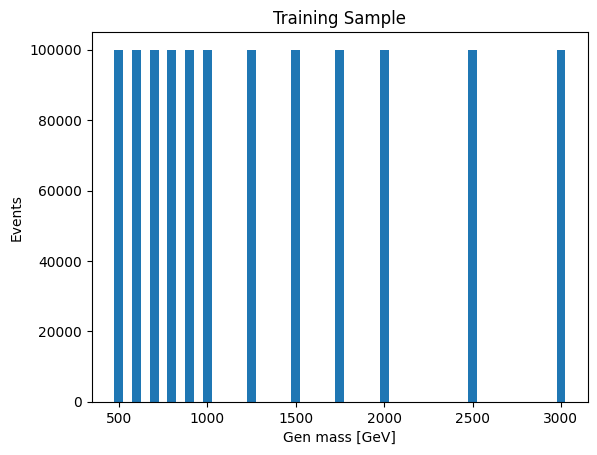

In [11]:
if SanityCheckPlots:
    plt.hist(TrainingDF["Mass"], bins = int((Masses[-1] - Masses[0])/50) + 1,
             range = [Masses[0]-25, Masses[-1]+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Training Sample")

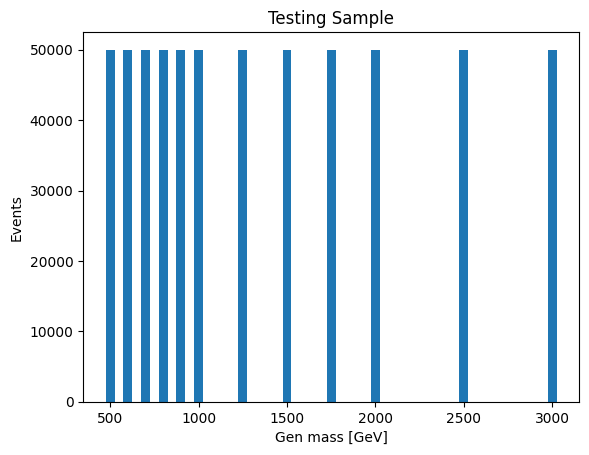

In [12]:
if SanityCheckPlots:
    plt.hist(TestingDF["Mass"], bins = int((Masses[-1] - Masses[0])/50) + 1,
             range = [Masses[0]-25, Masses[-1]+25], rwidth = 1)
    plt.xlabel("Gen mass [GeV]")
    plt.ylabel("Events")
    plt.title("Testing Sample")

/tmp/ipykernel_1221/1985655967.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


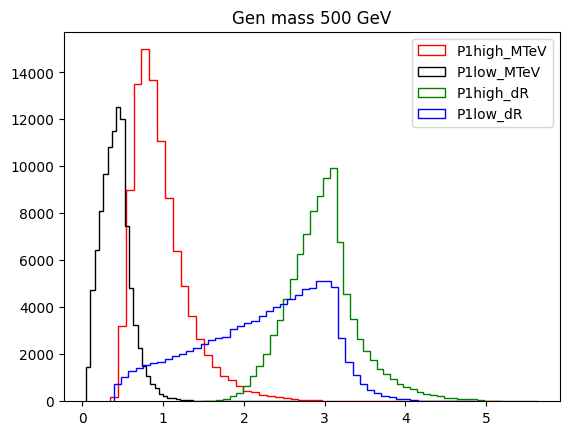

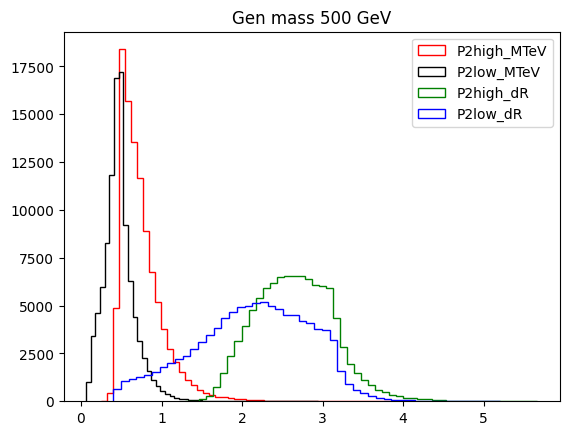

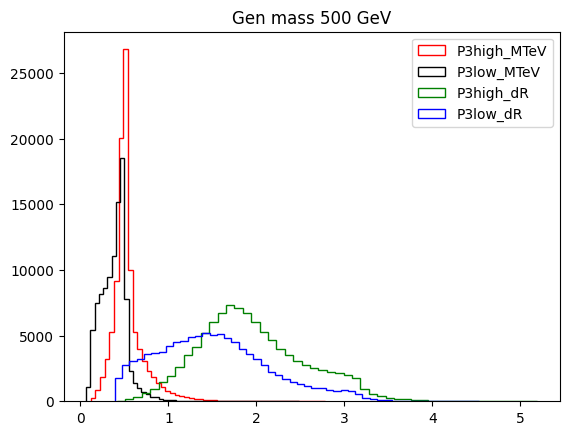

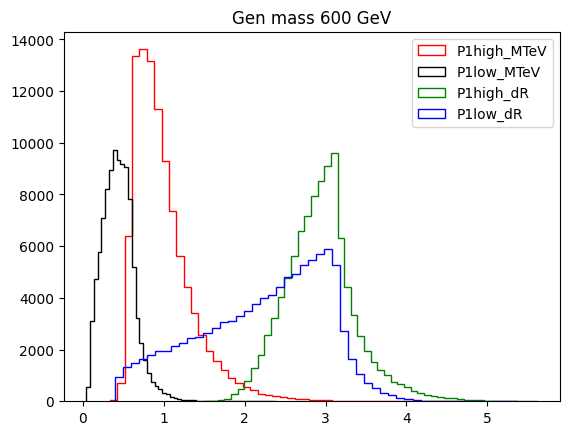

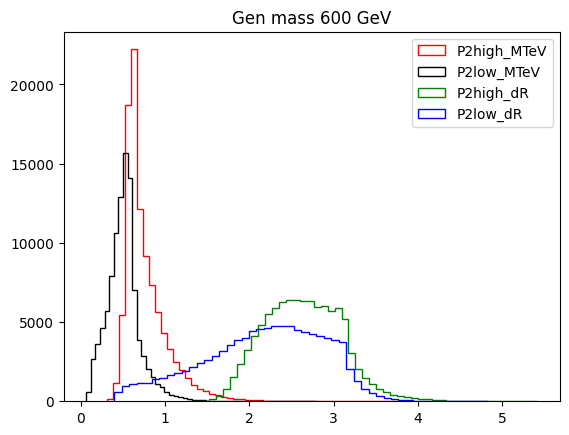

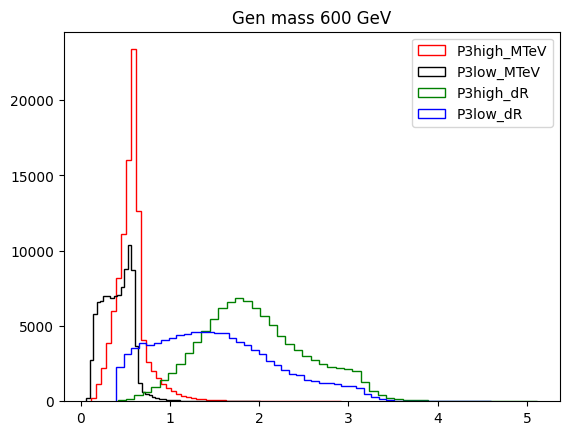

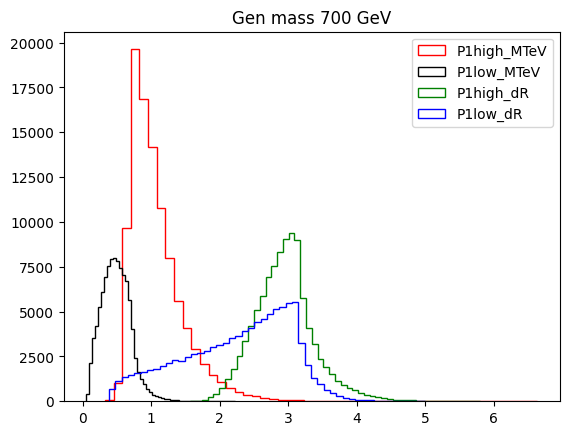

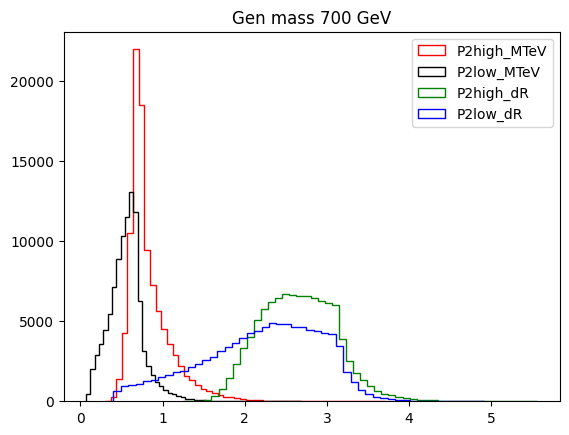

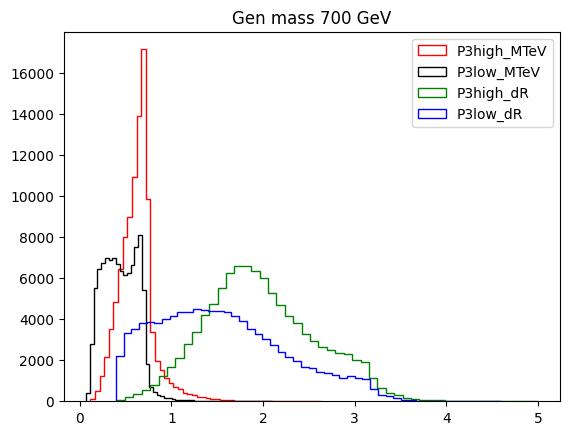

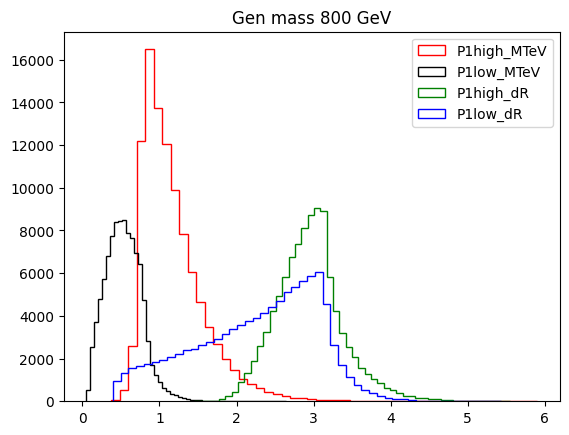

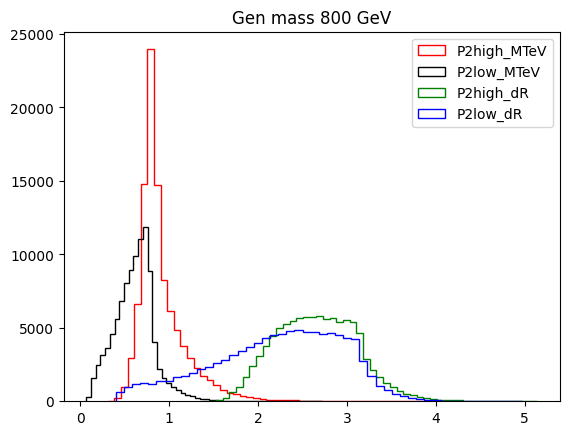

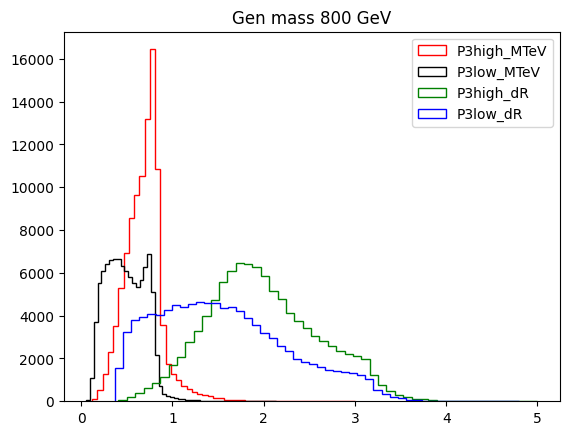

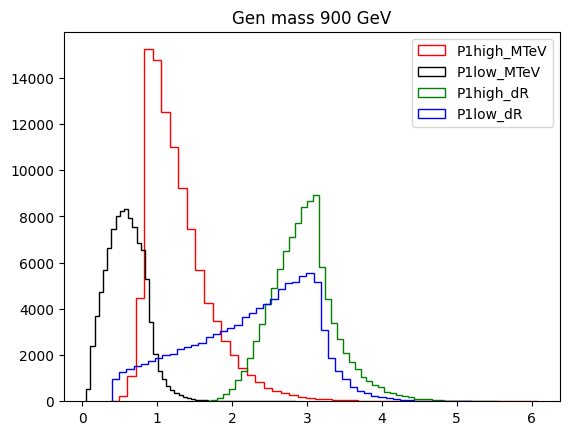

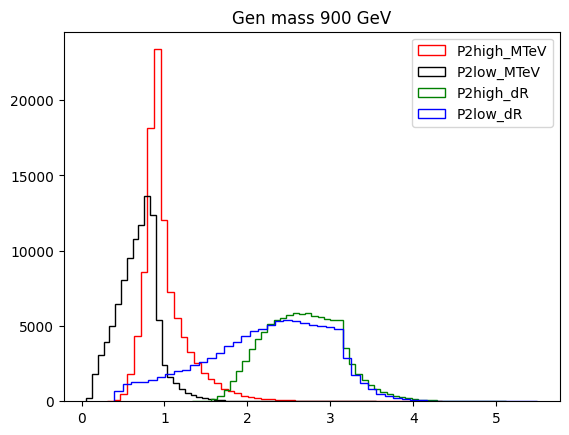

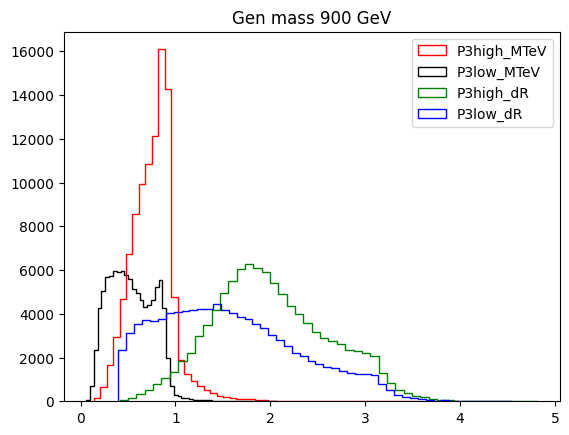

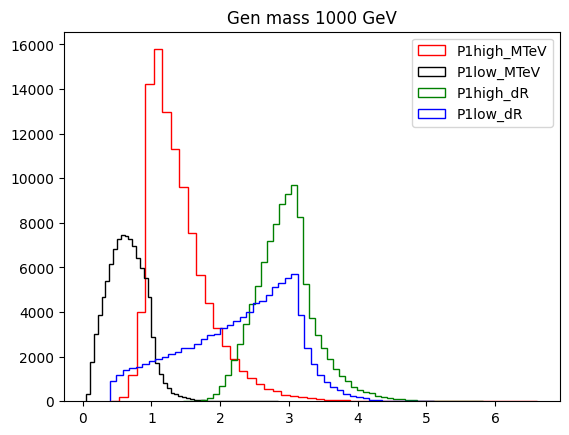

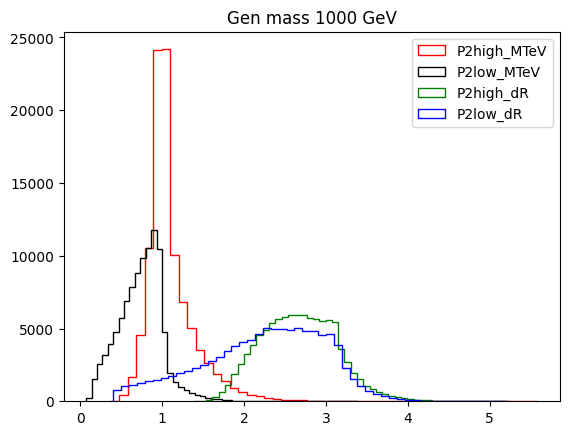

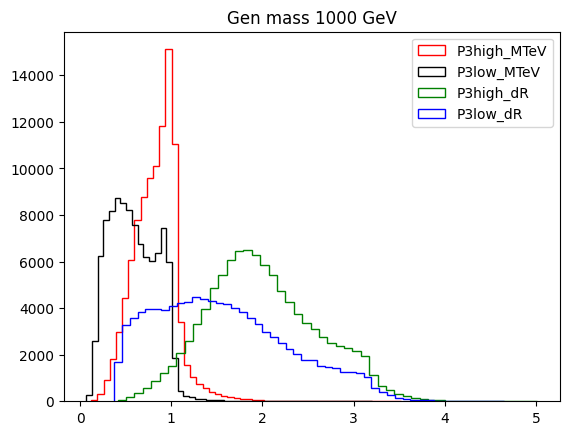

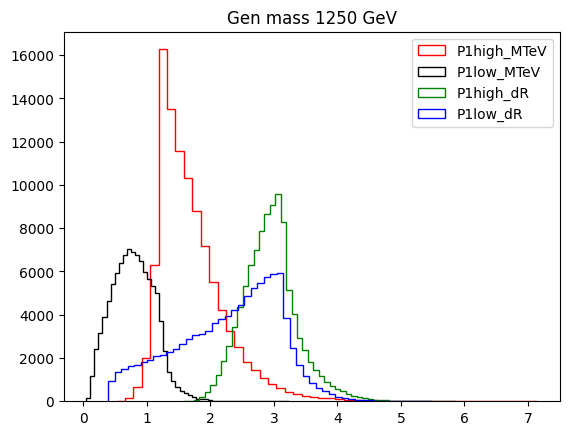

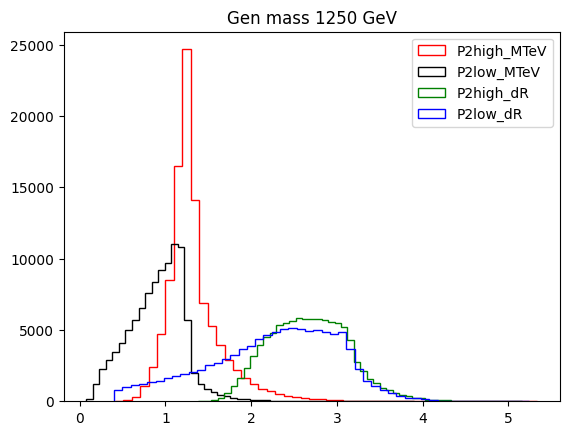

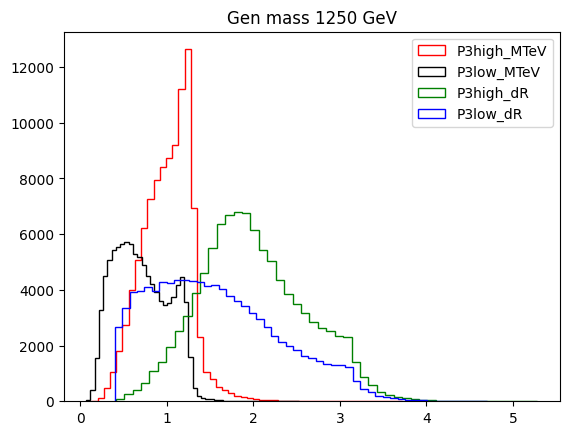

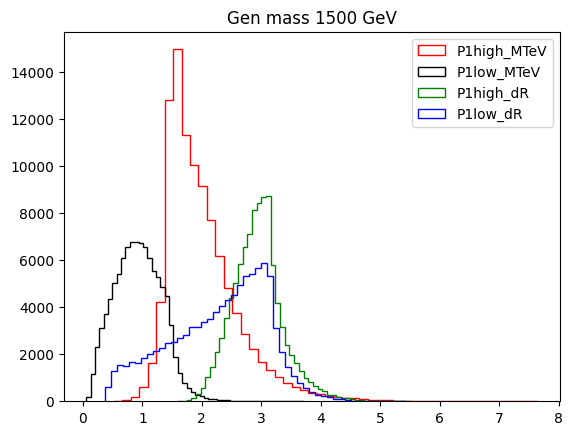

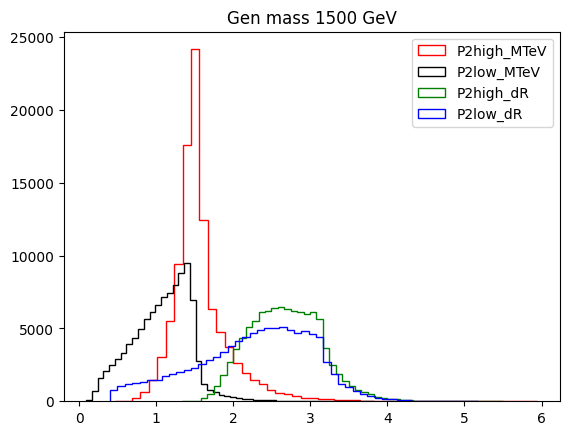

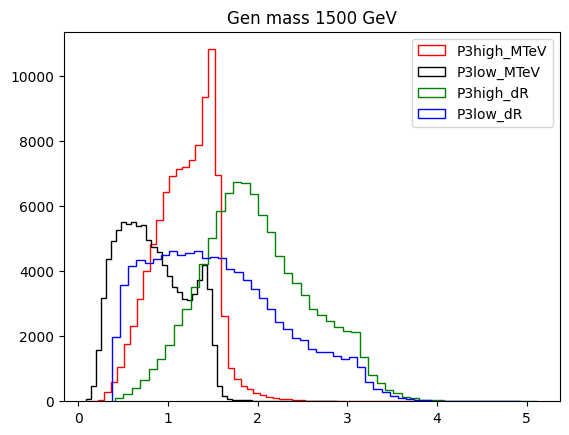

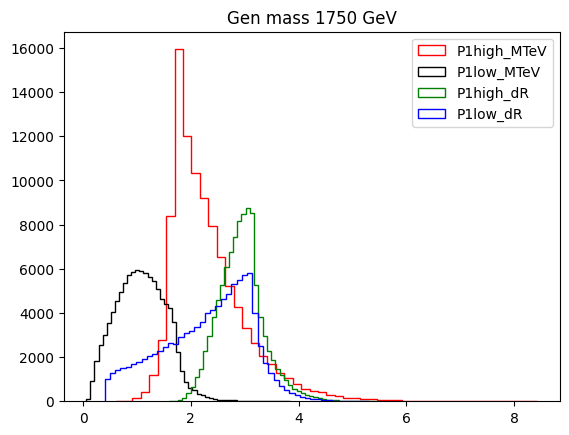

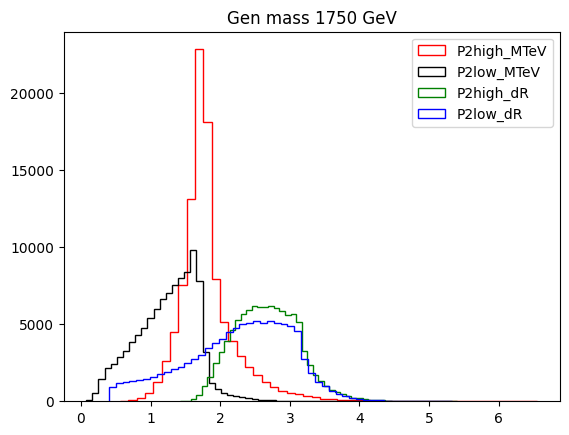

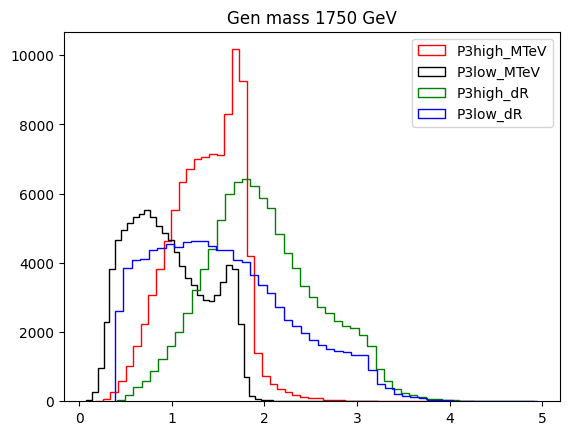

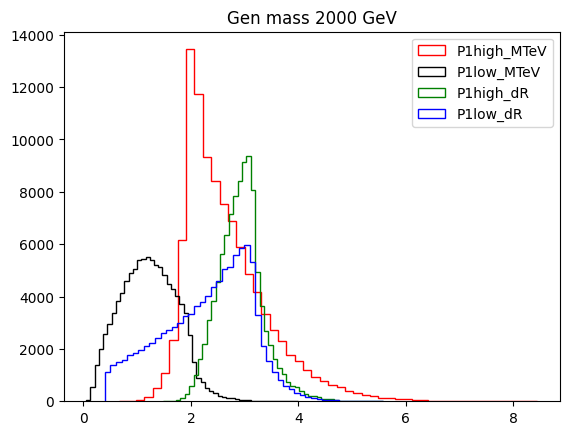

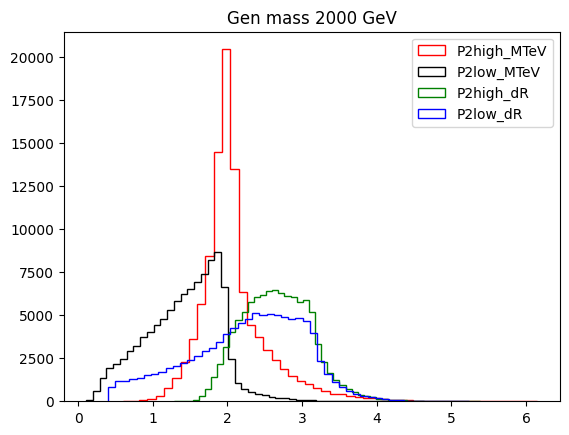

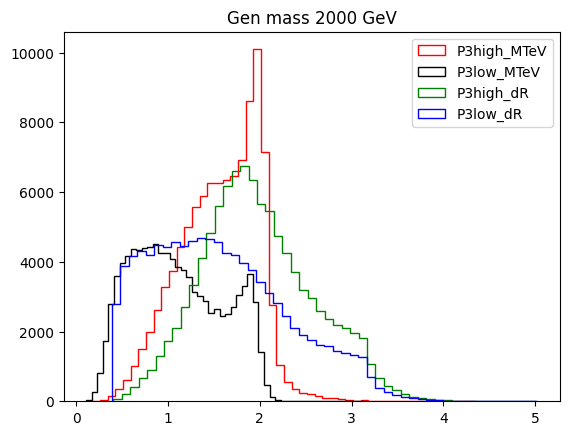

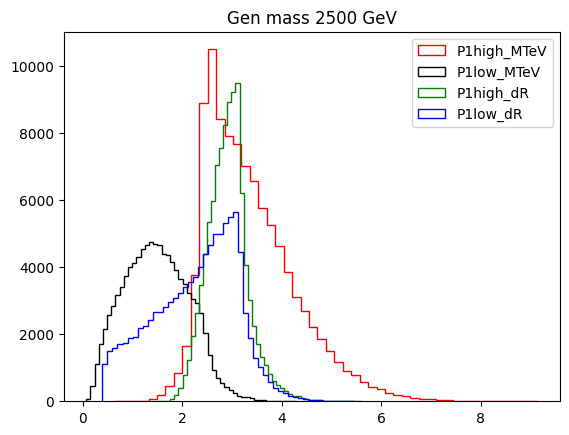

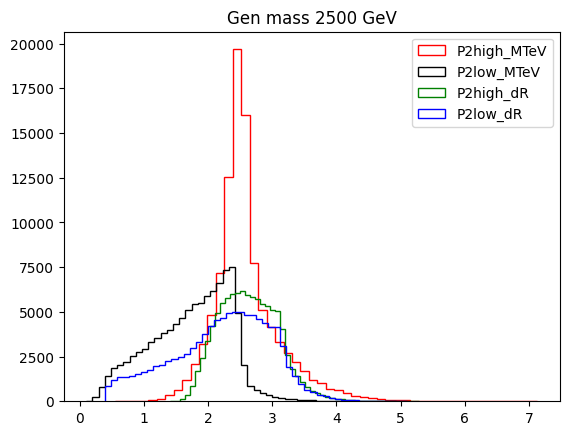

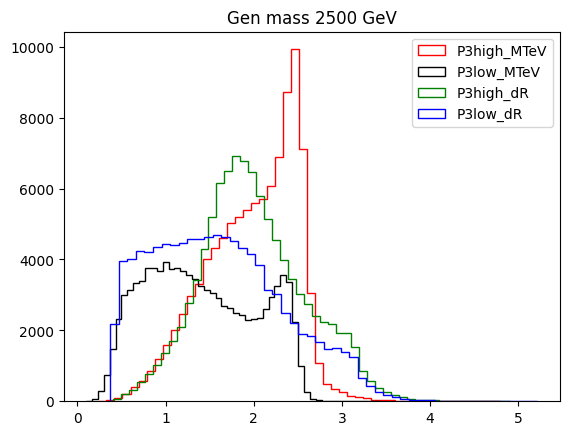

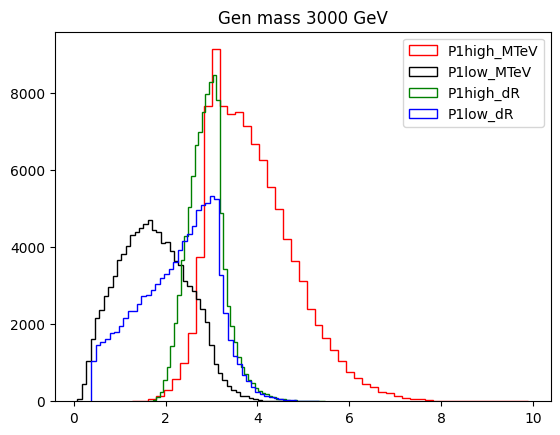

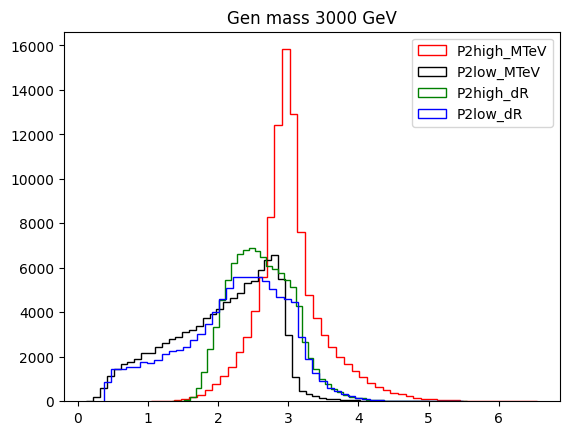

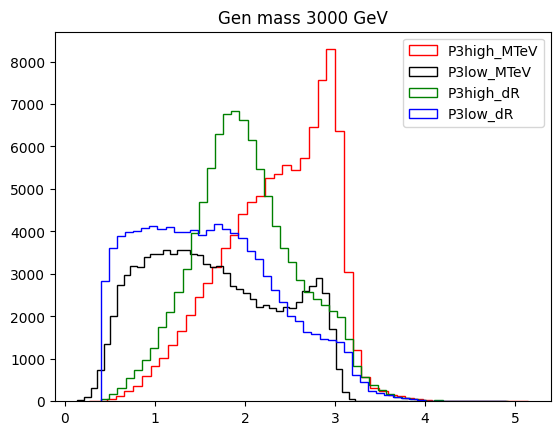

In [13]:
if SanityCheckPlots:
    for Mass in Masses:
        for Pair in ["P1", "P2", "P3"]:
            TrainingDF_temp = TrainingDF.loc[TrainingDF["Mass"] == Mass]
            plt.figure()
            plt.hist(TrainingDF_temp[Pair + "high_MTeV"], bins = 50, histtype = "step", color = "r", label = Pair + "high_MTeV")
            plt.hist(TrainingDF_temp[Pair + "low_MTeV"], bins = 50, histtype = "step", color = "k", label = Pair + "low_MTeV")
            plt.hist(TrainingDF_temp[Pair + "high_dR"], bins = 50, histtype = "step", color = "g", label = Pair + "high_dR")
            plt.hist(TrainingDF_temp[Pair + "low_dR"], bins = 50, histtype = "step", color = "b", label = Pair + "low_dR")
            plt.legend()
            plt.title("Gen mass " + str(Mass) + " GeV")

In [14]:
InputList = ["fourjetmasstev", "P1high_MTeV", "P1low_MTeV", "P1high_dR", "P1low_dR",
             "fourjetmasstev", "P2high_MTeV", "P2low_MTeV", "P2high_dR", "P2low_dR",
             "fourjetmasstev", "P3high_MTeV", "P3low_MTeV", "P3high_dR", "P3low_dR",]


TrainingInputs = TrainingDF[InputList].to_numpy()
TrainingTruth = TrainingDF["Truth_QSMD"].to_numpy()

TestingInputs = TestingDF[InputList].to_numpy()

In [15]:
print(TrainingInputs.shape)
print(TrainingTruth.shape)
print(TestingInputs.shape)

(1200000, 15)
(1200000,)
(600000, 15)


In [16]:
NotebookName = "quad_sum_mass_diff_CNN_more"
ResultsDir = "results_temp/results_" + NotebookName + "/"
if not os.path.exists(ResultsDir):
    os.makedirs(ResultsDir)

In [17]:
def model_CNN():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(3*5, ), name="model_in"),
        tf.keras.layers.Reshape((3,5, 1)),
        tf.keras.layers.Conv2D(16, (2,3), activation='relu'),
        tf.keras.layers.Conv2D(8, (2,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(3, activation='softmax', name="model_out")],
        name = "ModelCNN"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [18]:
def model_CNN_more():
    Model = tf.keras.Sequential([
        tf.keras.Input(shape=(3*5, ), name="model_in"),
        tf.keras.layers.Reshape((3,5, 1)),
        tf.keras.layers.Conv2D(32, (2,3), activation='relu'),
        tf.keras.layers.Conv2D(16, (2,3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(3, activation='softmax', name="model_out")],
        name = "ModelCNNMore"
    )
    Model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
    return Model

In [19]:
#Model = model_CNN()
Model = model_CNN_more()

2023-12-07 15:12:29.036502: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-07 15:12:29.553700: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11311 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:65:00.0, compute capability: 6.0


In [20]:
Model.summary()

Model: "ModelCNNMore"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 3, 5, 1)           0         
                                                                 
 conv2d (Conv2D)             (None, 2, 3, 32)          224       
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 1, 16)          3088      
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 model_out (Dense)           (None, 3)                 27        
                                                                 
Total params: 3,475
Trainable params: 3,475
Non-traina

In [21]:
import pydot
import graphviz
tf.keras.utils.plot_model(Model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(ResultsDir + "Model.h5", save_best_only = True, monitor = "val_loss", mode = "min")

History = Model.fit(TrainingInputs, TrainingTruth, batch_size = 5000,
                    epochs = 100, validation_split = 0.2, callbacks=[checkpoint])

Epoch 1/100


2023-12-07 15:12:46.652240: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


192/192 [==============================] - 46s 6ms/step - loss: 0.8043 - accuracy: 0.6435 - val_loss: 0.6391 - val_accuracy: 0.7138
Epoch 2/100
192/192 [==============================] - 1s 4ms/step - loss: 0.5894 - accuracy: 0.7380 - val_loss: 0.5561 - val_accuracy: 0.7586
Epoch 3/100
192/192 [==============================] - 1s 4ms/step - loss: 0.5353 - accuracy: 0.7702 - val_loss: 0.5195 - val_accuracy: 0.7802
Epoch 4/100
192/192 [==============================] - 1s 4ms/step - loss: 0.5047 - accuracy: 0.7847 - val_loss: 0.4935 - val_accuracy: 0.7888
Epoch 5/100
192/192 [==============================] - 1s 4ms/step - loss: 0.4816 - accuracy: 0.7962 - val_loss: 0.4740 - val_accuracy: 0.7992
Epoch 6/100
192/192 [==============================] - 1s 4ms/step - loss: 0.4714 - accuracy: 0.8006 - val_loss: 0.4694 - val_accuracy: 0.8008
Epoch 7/100
192/192 [==============================] - 1s 4ms/step - loss: 0.4677 - accuracy: 0.8019 - val_loss: 0.4666 - val_accuracy: 0.8030
Epoch 8/10

192/192 [==============================] - 1s 4ms/step - loss: 0.4329 - accuracy: 0.8138 - val_loss: 0.4334 - val_accuracy: 0.8129
Epoch 59/100
192/192 [==============================] - 1s 4ms/step - loss: 0.4330 - accuracy: 0.8137 - val_loss: 0.4341 - val_accuracy: 0.8127
Epoch 60/100
192/192 [==============================] - 1s 4ms/step - loss: 0.4325 - accuracy: 0.8139 - val_loss: 0.4335 - val_accuracy: 0.8126
Epoch 61/100
192/192 [==============================] - 1s 4ms/step - loss: 0.4325 - accuracy: 0.8137 - val_loss: 0.4327 - val_accuracy: 0.8128
Epoch 62/100
192/192 [==============================] - 1s 4ms/step - loss: 0.4326 - accuracy: 0.8139 - val_loss: 0.4328 - val_accuracy: 0.8128
Epoch 63/100
192/192 [==============================] - 1s 4ms/step - loss: 0.4322 - accuracy: 0.8136 - val_loss: 0.4330 - val_accuracy: 0.8126
Epoch 64/100
192/192 [==============================] - 1s 4ms/step - loss: 0.4317 - accuracy: 0.8140 - val_loss: 0.4324 - val_accuracy: 0.8132
Epoch

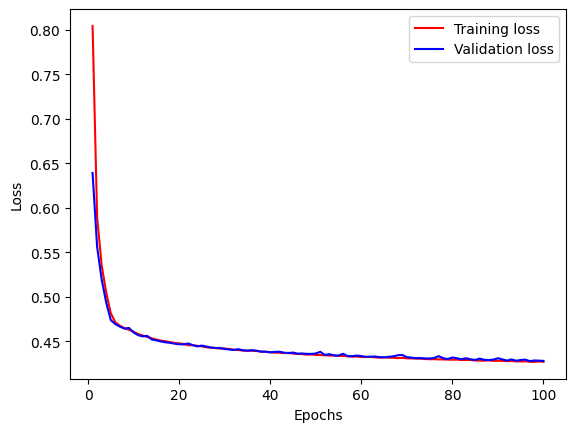

In [23]:
Loss = History.history["loss"]
ValLoss = History.history["val_loss"]
Epochs = range(1, len(Loss) + 1)

plt.plot(Epochs, Loss, "r", label="Training loss")
plt.plot(Epochs, ValLoss, "b", label="Validation loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
    
plt.savefig(ResultsDir + "Loss_vs_Epochs.png")

In [24]:
#Model.save(ResultsDir + "Model.h5")

ModelTest = tf.keras.models.load_model(ResultsDir + "Model.h5")
TestingOutputs = ModelTest.predict(TestingInputs, batch_size = 5000)

120/120 [==============================] - 0s 1ms/step


In [25]:
TestingOutputs[0] #ML raw output is the probability of 3 sparse categories

array([0.00091531, 0.7725549 , 0.22652982], dtype=float32)

In [26]:
TestingPredictions = np.argmax(TestingOutputs, axis = 1) #pick the highest probability as ML output

In [27]:
print(TestingPredictions.shape)
print(TestingPredictions[0])

(600000,)
1


In [28]:
TestingDF["Pred"] = TestingPredictions.tolist()

In [29]:
TestingDF

,Mass,evt_trig,fourjetmasstev,Mjj_avg_dRpairing_GeV,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,P1high_M,P1low_M,P2high_M,P2low_M,P3high_M,P3low_M,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,Pred
0,500,1,1.665246,569.138611,1.083193,0.373950,0.676399,0.612059,0.610390,0.527888,2.782113,1.547665,1.907177,2.159548,2.022496,1.730264,1083.193410,373.949755,676.398680,612.058930,610.389668,527.887546,728.571582,644.228805,569.138607,2,2,2,3.560032e+05,4.367370e+04,1.296359e+04,2,1
1,500,1,1.109070,235.760468,0.703446,0.375377,0.497867,0.468088,0.342566,0.128955,3.113047,2.368026,2.692501,1.955640,1.254488,0.457324,703.445644,375.376717,497.867207,468.088484,342.566192,128.954730,539.411181,482.977846,235.760461,2,1,1,5.692109e+04,1.022894e+03,1.624600e+05,1,1
2,500,1,1.522245,473.871796,0.884906,0.596236,0.743461,0.438657,0.513220,0.434524,3.090241,3.215255,2.348969,1.981968,1.479761,1.521776,884.905691,596.236004,743.460797,438.656782,513.219915,434.523672,740.570848,591.058789,473.871794,2,2,2,1.574138e+05,6.303615e+04,4.461916e+03,2,2
3,500,1,2.525532,472.603851,2.169740,0.265412,0.801181,0.651792,0.703891,0.241316,2.993525,2.251249,2.862716,2.342220,1.928741,0.635207,2169.740485,265.412339,801.180826,651.791965,703.891486,241.316244,1217.576412,726.486396,472.603865,2,2,2,2.843065e+06,1.137507e+05,1.084890e+05,2,1
4,500,1,1.569428,567.971130,0.936199,0.199743,0.899177,0.482994,0.512215,0.500105,2.279822,0.934763,2.700373,2.369658,1.880583,1.437924,936.198882,199.743343,899.176959,482.993652,512.215294,500.104844,567.971112,691.085306,506.160069,0,2,2,2.804235e+05,1.596315e+05,1.492244e+02,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,3000,1,6.142254,2605.686768,3.726679,2.139488,2.616437,2.594937,2.142181,1.065793,3.557276,3.214979,2.495388,3.063509,2.823131,2.938442,3726.679280,2139.487545,2616.436654,2594.936898,2142.180822,1065.792656,2933.083412,2605.686776,1603.986739,1,1,0,1.268544e+06,3.111970e+05,4.477012e+06,1,1
599996,3000,1,5.129152,1248.353516,2.798038,1.912490,2.437130,2.124802,2.054564,0.442143,3.294043,2.397300,2.841346,3.037939,1.969007,0.621246,2798.037987,1912.490264,2437.130249,2124.802439,2054.564499,442.142653,2355.264125,2280.966344,1248.353576,2,0,0,1.223466e+06,1.082793e+06,7.436482e+06,1,1
599997,3000,1,6.280539,1231.659424,4.524592,1.535514,3.297457,1.661724,1.345551,1.117768,4.409254,3.134380,3.414219,3.425090,1.548936,1.288221,4524.592364,1535.514102,3297.457153,1661.724282,1345.551306,1117.767633,3030.053233,2479.590718,1231.659470,2,1,0,4.469101e+06,1.879463e+06,6.279999e+06,1,2
599998,3000,1,6.048077,1822.411743,3.156473,2.037133,2.874936,2.729543,2.142006,1.502817,2.828993,3.045544,2.500509,3.260420,1.784493,1.213136,3156.472845,2037.132867,2874.936016,2729.542849,2142.006216,1502.817188,2596.802856,2802.239432,1822.411702,2,1,1,9.515969e+05,8.878807e+04,2.977710e+06,1,1


In [30]:
AccPred = []
AccdR = []
Acc0 = []
Acc1 = []
Acc2 = []
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    TestingDF_pred = TestingDF_temp.loc[TestingDF_temp["Pred"]==TestingDF_temp["Truth_QSMD"]]
    TestingDF_dR = TestingDF_temp.loc[TestingDF_temp["dRi"]==TestingDF_temp["Truth_QSMD"]]
    TestingDF_0 = TestingDF_temp.loc[0==TestingDF_temp["Truth_QSMD"]]
    TestingDF_1 = TestingDF_temp.loc[1==TestingDF_temp["Truth_QSMD"]]
    TestingDF_2 = TestingDF_temp.loc[2==TestingDF_temp["Truth_QSMD"]]

    AccPred.append(float(len(TestingDF_pred.index))/len(TestingDF_temp.index))
    AccdR.append(float(len(TestingDF_dR.index))/len(TestingDF_temp.index))
    Acc0.append(float(len(TestingDF_0.index))/len(TestingDF_temp.index))
    Acc1.append(float(len(TestingDF_1.index))/len(TestingDF_temp.index))
    Acc2.append(float(len(TestingDF_2.index))/len(TestingDF_temp.index))

In [31]:
AccPredAvg = "Avg %.2f" % float(sum(AccPred)/len(AccPred))
AccdRAvg = "Avg %.2f" % float(sum(AccdR)/len(AccdR))
Acc0Avg = "Avg %.2f" % float(sum(Acc0)/len(Acc0))
Acc1Avg = "Avg %.2f" % float(sum(Acc1)/len(Acc1))
Acc2Avg = "Avg %.2f" % float(sum(Acc2)/len(Acc2))

print(["%.2f" % i for i in AccPred], AccPredAvg)
print(["%.2f" % i for i in AccdR], AccdRAvg)
print(["%.2f" % i for i in Acc0], Acc0Avg)
print(["%.2f" % i for i in Acc1], Acc1Avg)
print(["%.2f" % i for i in Acc2], Acc2Avg)

['0.67', '0.79', '0.81', '0.81', '0.81', '0.79', '0.78', '0.82', '0.84', '0.86', '0.89', '0.89'] Avg 0.81
['0.40', '0.26', '0.20', '0.18', '0.16', '0.14', '0.12', '0.11', '0.11', '0.11', '0.10', '0.07'] Avg 0.16
['0.04', '0.10', '0.14', '0.16', '0.16', '0.18', '0.19', '0.20', '0.19', '0.19', '0.17', '0.16'] Avg 0.16
['0.30', '0.41', '0.44', '0.45', '0.47', '0.48', '0.50', '0.51', '0.51', '0.51', '0.51', '0.54'] Avg 0.47
['0.65', '0.49', '0.43', '0.39', '0.37', '0.35', '0.32', '0.30', '0.29', '0.30', '0.32', '0.29'] Avg 0.37


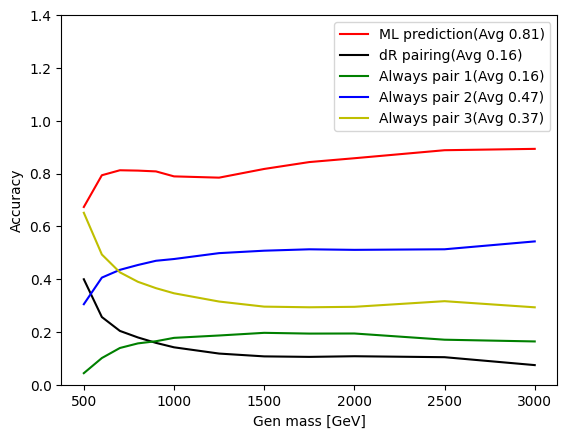

In [32]:
plt.plot(Masses, AccPred, "r", label = "ML prediction(" + AccPredAvg + ")")
plt.plot(Masses, AccdR, "k", label = "dR pairing(" + AccdRAvg + ")")
plt.plot(Masses, Acc0, "g", label = "Always pair 1(" + Acc0Avg + ")")
plt.plot(Masses, Acc1, "b", label = "Always pair 2(" + Acc1Avg + ")")
plt.plot(Masses, Acc2, "y", label = "Always pair 3(" + Acc2Avg + ")")
plt.legend()
plt.xlabel("Gen mass [GeV]")
plt.ylabel("Accuracy")
plt.ylim(0, 1.4)
plt.savefig(ResultsDir + "Accuracy_vs_mass.png")

In [33]:
P1Mi = TestingDF.columns.get_loc("P1M")
#TestingDF["dR_M"] = TestingDF.apply(lambda row: row.iloc[row["dRi"]], axis=1)
TestingDF["dR_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["dRi"]]
TestingDF["Truth_high_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Truth_high"]]
TestingDF["Truth_avg_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Truth_avg"]]
TestingDF["Pred_M"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1Mi + TestingDF["Pred"]]
TestingDF

,Mass,evt_trig,fourjetmasstev,Mjj_avg_dRpairing_GeV,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,P1high_M,P1low_M,P2high_M,P2low_M,P3high_M,P3low_M,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M
0,500,1,1.665246,569.138611,1.083193,0.373950,0.676399,0.612059,0.610390,0.527888,2.782113,1.547665,1.907177,2.159548,2.022496,1.730264,1083.193410,373.949755,676.398680,612.058930,610.389668,527.887546,728.571582,644.228805,569.138607,2,2,2,3.560032e+05,4.367370e+04,1.296359e+04,2,1,569.138607,569.138607,569.138607,644.228805
1,500,1,1.109070,235.760468,0.703446,0.375377,0.497867,0.468088,0.342566,0.128955,3.113047,2.368026,2.692501,1.955640,1.254488,0.457324,703.445644,375.376717,497.867207,468.088484,342.566192,128.954730,539.411181,482.977846,235.760461,2,1,1,5.692109e+04,1.022894e+03,1.624600e+05,1,1,235.760461,482.977846,482.977846,482.977846
2,500,1,1.522245,473.871796,0.884906,0.596236,0.743461,0.438657,0.513220,0.434524,3.090241,3.215255,2.348969,1.981968,1.479761,1.521776,884.905691,596.236004,743.460797,438.656782,513.219915,434.523672,740.570848,591.058789,473.871794,2,2,2,1.574138e+05,6.303615e+04,4.461916e+03,2,2,473.871794,473.871794,473.871794,473.871794
3,500,1,2.525532,472.603851,2.169740,0.265412,0.801181,0.651792,0.703891,0.241316,2.993525,2.251249,2.862716,2.342220,1.928741,0.635207,2169.740485,265.412339,801.180826,651.791965,703.891486,241.316244,1217.576412,726.486396,472.603865,2,2,2,2.843065e+06,1.137507e+05,1.084890e+05,2,1,472.603865,472.603865,472.603865,726.486396
4,500,1,1.569428,567.971130,0.936199,0.199743,0.899177,0.482994,0.512215,0.500105,2.279822,0.934763,2.700373,2.369658,1.880583,1.437924,936.198882,199.743343,899.176959,482.993652,512.215294,500.104844,567.971112,691.085306,506.160069,0,2,2,2.804235e+05,1.596315e+05,1.492244e+02,2,2,567.971112,506.160069,506.160069,506.160069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,3000,1,6.142254,2605.686768,3.726679,2.139488,2.616437,2.594937,2.142181,1.065793,3.557276,3.214979,2.495388,3.063509,2.823131,2.938442,3726.679280,2139.487545,2616.436654,2594.936898,2142.180822,1065.792656,2933.083412,2605.686776,1603.986739,1,1,0,1.268544e+06,3.111970e+05,4.477012e+06,1,1,2605.686776,2605.686776,2933.083412,2605.686776
599996,3000,1,5.129152,1248.353516,2.798038,1.912490,2.437130,2.124802,2.054564,0.442143,3.294043,2.397300,2.841346,3.037939,1.969007,0.621246,2798.037987,1912.490264,2437.130249,2124.802439,2054.564499,442.142653,2355.264125,2280.966344,1248.353576,2,0,0,1.223466e+06,1.082793e+06,7.436482e+06,1,1,1248.353576,2355.264125,2355.264125,2280.966344
599997,3000,1,6.280539,1231.659424,4.524592,1.535514,3.297457,1.661724,1.345551,1.117768,4.409254,3.134380,3.414219,3.425090,1.548936,1.288221,4524.592364,1535.514102,3297.457153,1661.724282,1345.551306,1117.767633,3030.053233,2479.590718,1231.659470,2,1,0,4.469101e+06,1.879463e+06,6.279999e+06,1,2,1231.659470,2479.590718,3030.053233,1231.659470
599998,3000,1,6.048077,1822.411743,3.156473,2.037133,2.874936,2.729543,2.142006,1.502817,2.828993,3.045544,2.500509,3.260420,1.784493,1.213136,3156.472845,2037.132867,2874.936016,2729.542849,2142.006216,1502.817188,2596.802856,2802.239432,1822.411702,2,1,1,9.515969e+05,8.878807e+04,2.977710e+06,1,1,1822.411702,2802.239432,2802.239432,2802.239432


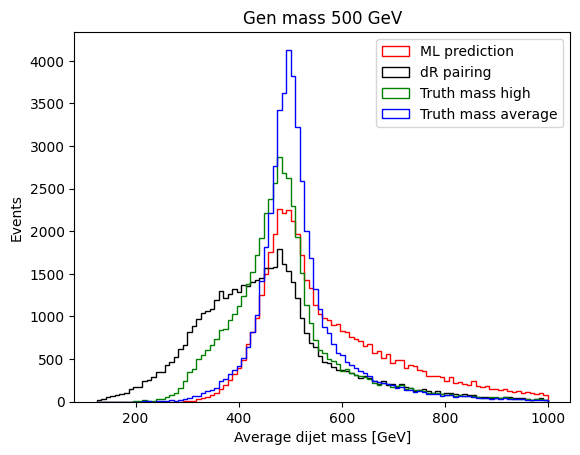

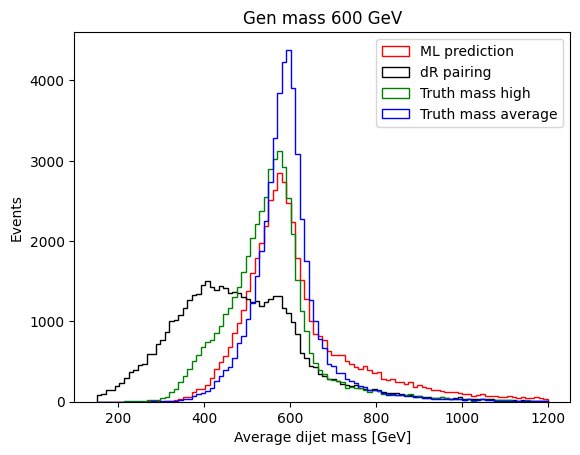

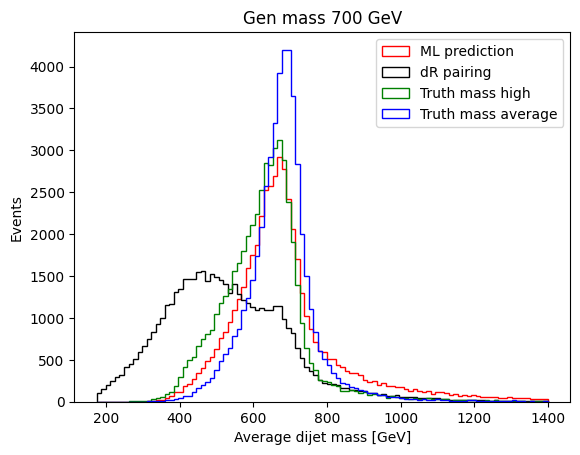

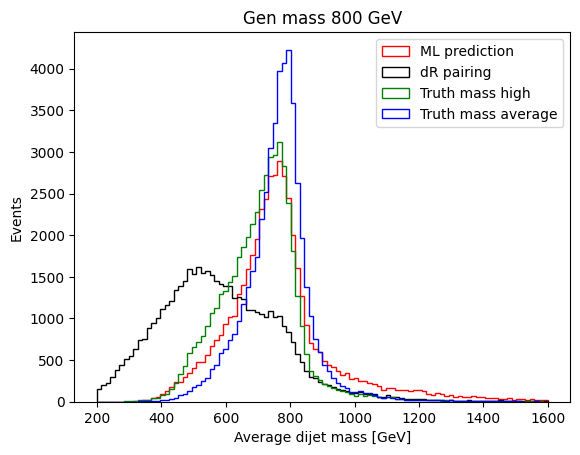

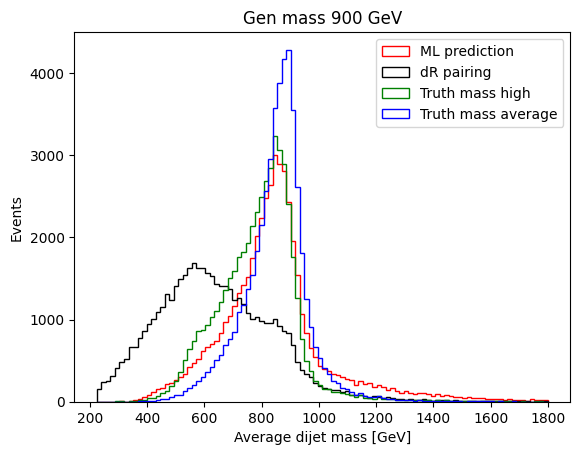

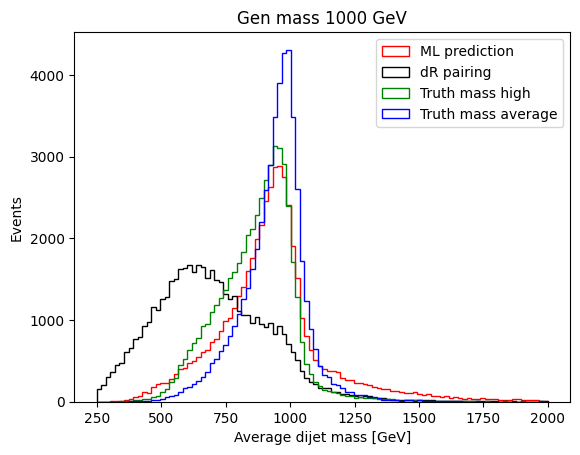

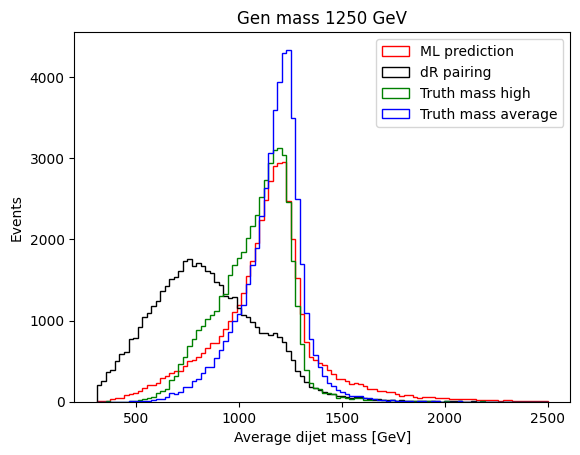

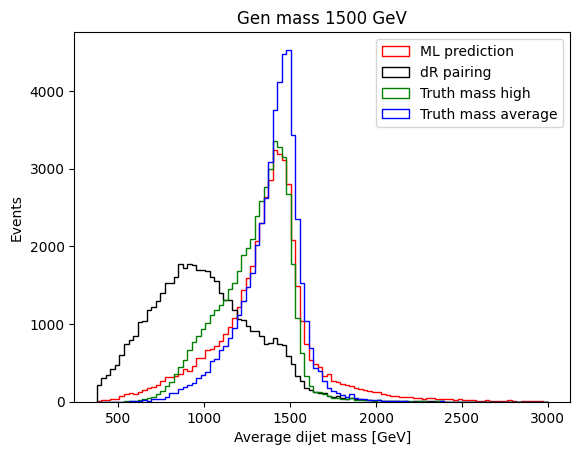

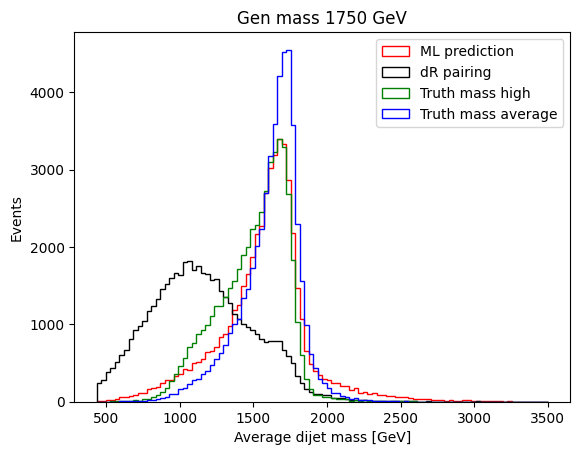

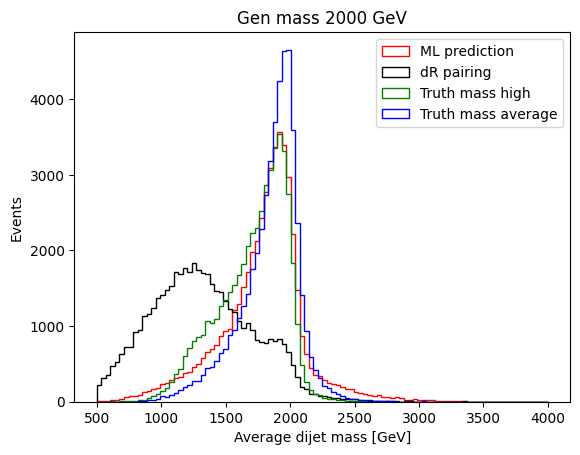

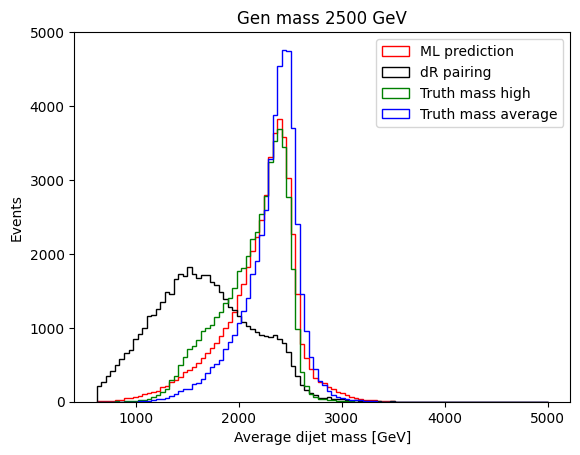

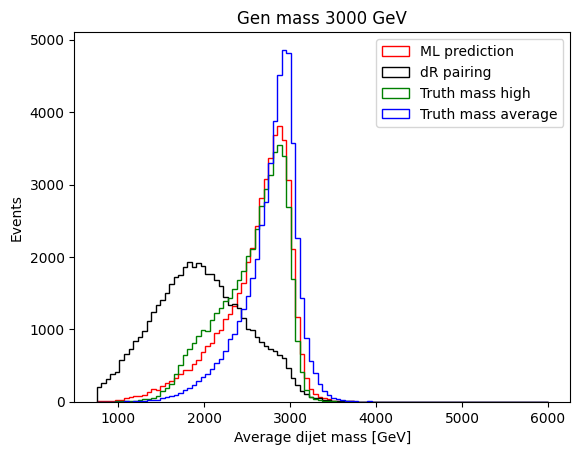

In [34]:
# for each gen mass sample, plot average dijet mass
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_M"], bins = 100, range = [Mass/4, Mass*2], histtype = "step",
             color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_M"], bins = 100, range = [Mass/4, Mass*2], histtype = "step",
             color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_M"], bins = 100, range = [Mass/4, Mass*2], histtype = "step",
             color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_M"], bins = 100, range = [Mass/4, Mass*2], histtype = "step",
             color = "b", label = "Truth mass average")
    plt.legend()
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("Average dijet mass [GeV]")
    plt.ylabel("Events")
    plt.savefig(ResultsDir + "Average_dijet_mass_" + str(Mass) + "GeV.png")

In [35]:
P1M_high_i = TestingDF.columns.get_loc("P1high_M")
TestingDF["dR_M_high"] = TestingDF.to_numpy()[
    np.arange(len(TestingDF)), P1M_high_i + TestingDF["dRi"]*2]
TestingDF["Truth_high_M_high"] = TestingDF.to_numpy()[
    np.arange(len(TestingDF)), P1M_high_i + TestingDF["Truth_high"]*2]
TestingDF["Truth_avg_M_high"] = TestingDF.to_numpy()[
    np.arange(len(TestingDF)), P1M_high_i + TestingDF["Truth_avg"]*2]
TestingDF["Pred_M_high"] = TestingDF.to_numpy()[
    np.arange(len(TestingDF)), P1M_high_i + TestingDF["Pred"]*2]
TestingDF

,Mass,evt_trig,fourjetmasstev,Mjj_avg_dRpairing_GeV,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,P1high_M,P1low_M,P2high_M,P2low_M,P3high_M,P3low_M,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M,dR_M_high,Truth_high_M_high,Truth_avg_M_high,Pred_M_high
0,500,1,1.665246,569.138611,1.083193,0.373950,0.676399,0.612059,0.610390,0.527888,2.782113,1.547665,1.907177,2.159548,2.022496,1.730264,1083.193410,373.949755,676.398680,612.058930,610.389668,527.887546,728.571582,644.228805,569.138607,2,2,2,3.560032e+05,4.367370e+04,1.296359e+04,2,1,569.138607,569.138607,569.138607,644.228805,610.389668,610.389668,610.389668,676.398680
1,500,1,1.109070,235.760468,0.703446,0.375377,0.497867,0.468088,0.342566,0.128955,3.113047,2.368026,2.692501,1.955640,1.254488,0.457324,703.445644,375.376717,497.867207,468.088484,342.566192,128.954730,539.411181,482.977846,235.760461,2,1,1,5.692109e+04,1.022894e+03,1.624600e+05,1,1,235.760461,482.977846,482.977846,482.977846,342.566192,497.867207,497.867207,497.867207
2,500,1,1.522245,473.871796,0.884906,0.596236,0.743461,0.438657,0.513220,0.434524,3.090241,3.215255,2.348969,1.981968,1.479761,1.521776,884.905691,596.236004,743.460797,438.656782,513.219915,434.523672,740.570848,591.058789,473.871794,2,2,2,1.574138e+05,6.303615e+04,4.461916e+03,2,2,473.871794,473.871794,473.871794,473.871794,513.219915,513.219915,513.219915,513.219915
3,500,1,2.525532,472.603851,2.169740,0.265412,0.801181,0.651792,0.703891,0.241316,2.993525,2.251249,2.862716,2.342220,1.928741,0.635207,2169.740485,265.412339,801.180826,651.791965,703.891486,241.316244,1217.576412,726.486396,472.603865,2,2,2,2.843065e+06,1.137507e+05,1.084890e+05,2,1,472.603865,472.603865,472.603865,726.486396,703.891486,703.891486,703.891486,801.180826
4,500,1,1.569428,567.971130,0.936199,0.199743,0.899177,0.482994,0.512215,0.500105,2.279822,0.934763,2.700373,2.369658,1.880583,1.437924,936.198882,199.743343,899.176959,482.993652,512.215294,500.104844,567.971112,691.085306,506.160069,0,2,2,2.804235e+05,1.596315e+05,1.492244e+02,2,2,567.971112,506.160069,506.160069,506.160069,936.198882,512.215294,512.215294,512.215294
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,3000,1,6.142254,2605.686768,3.726679,2.139488,2.616437,2.594937,2.142181,1.065793,3.557276,3.214979,2.495388,3.063509,2.823131,2.938442,3726.679280,2139.487545,2616.436654,2594.936898,2142.180822,1065.792656,2933.083412,2605.686776,1603.986739,1,1,0,1.268544e+06,3.111970e+05,4.477012e+06,1,1,2605.686776,2605.686776,2933.083412,2605.686776,2616.436654,2616.436654,3726.679280,2616.436654
599996,3000,1,5.129152,1248.353516,2.798038,1.912490,2.437130,2.124802,2.054564,0.442143,3.294043,2.397300,2.841346,3.037939,1.969007,0.621246,2798.037987,1912.490264,2437.130249,2124.802439,2054.564499,442.142653,2355.264125,2280.966344,1248.353576,2,0,0,1.223466e+06,1.082793e+06,7.436482e+06,1,1,1248.353576,2355.264125,2355.264125,2280.966344,2054.564499,2798.037987,2798.037987,2437.130249
599997,3000,1,6.280539,1231.659424,4.524592,1.535514,3.297457,1.661724,1.345551,1.117768,4.409254,3.134380,3.414219,3.425090,1.548936,1.288221,4524.592364,1535.514102,3297.457153,1661.724282,1345.551306,1117.767633,3030.053233,2479.590718,1231.659470,2,1,0,4.469101e+06,1.879463e+06,6.279999e+06,1,2,1231.659470,2479.590718,3030.053233,1231.659470,1345.551306,3297.457153,4524.592364,1345.551306
599998,3000,1,6.048077,1822.411743,3.156473,2.037133,2.874936,2.729543,2.142006,1.502817,2.828993,3.045544,2.500509,3.260420,1.784493,1.213136,3156.472845,2037.132867,2874.936016,2729.542849,2142.006216,1502.817188,2596.802856,2802.239432,1822.411702,2,1,1,9.515969e+05,8.878807e+04,2.977710e+06,1,1,1822.411702,2802.239432,2802.239432,2802.239432,2142.006216,2874.936016,2874.936016,2

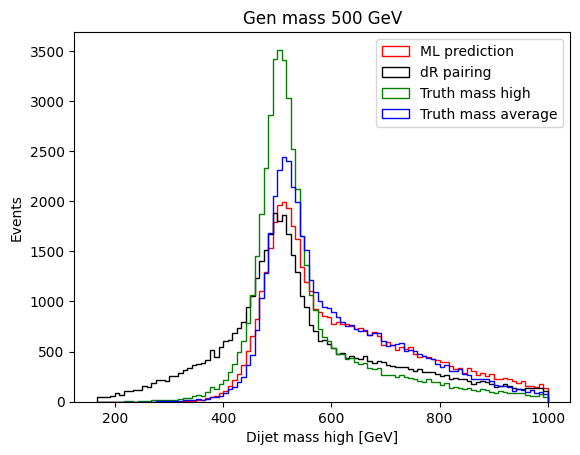

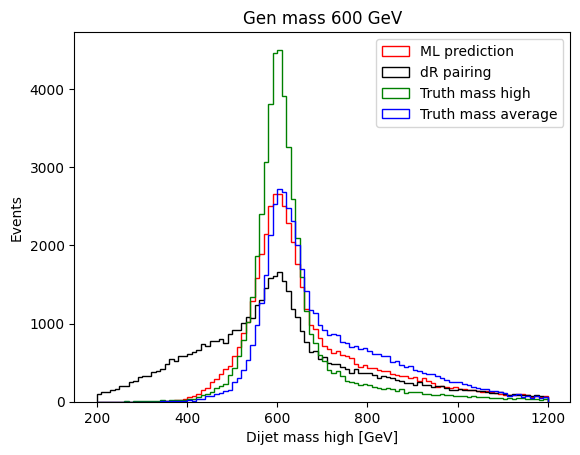

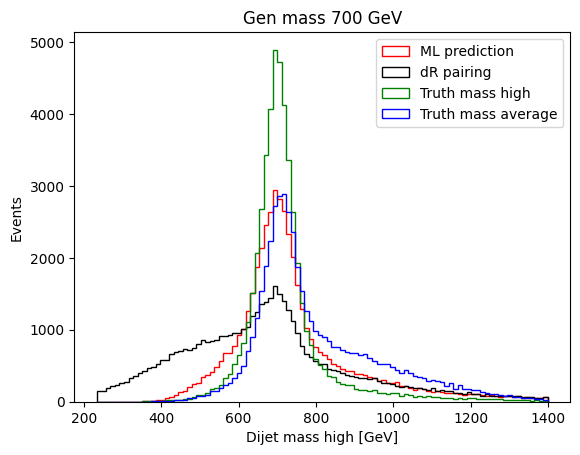

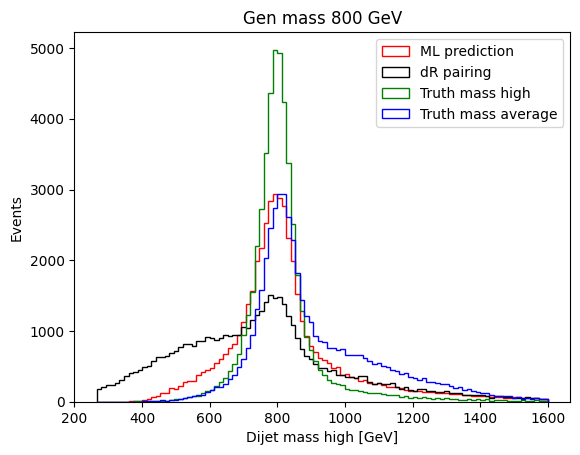

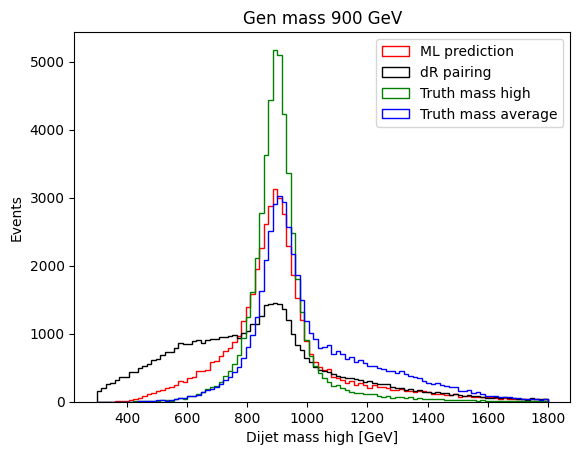

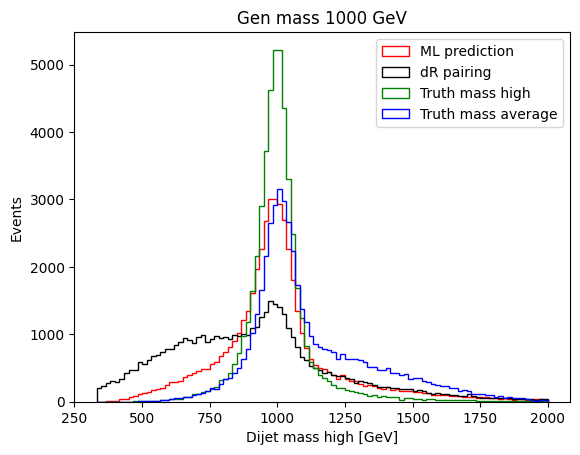

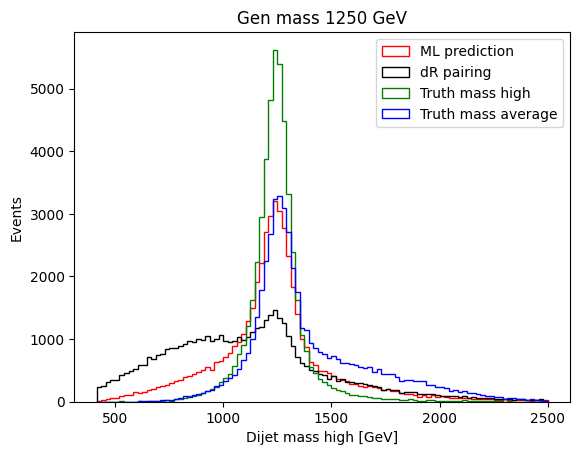

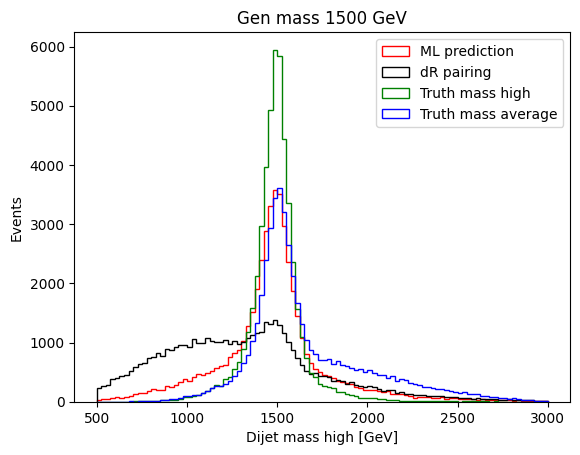

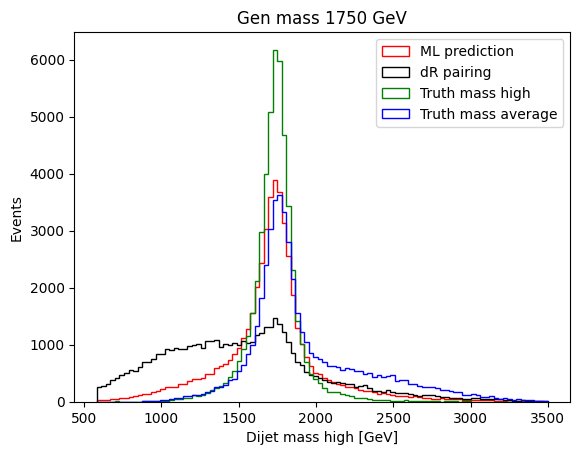

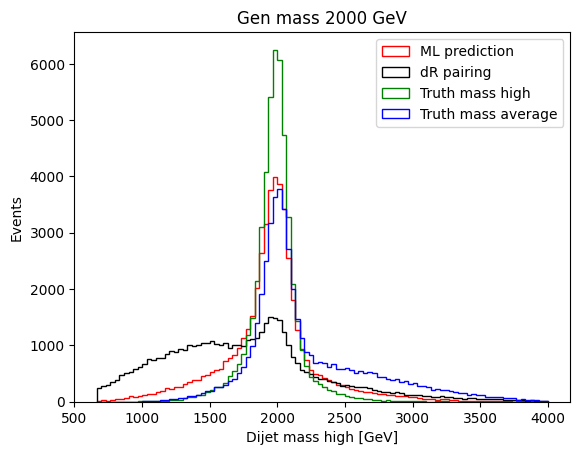

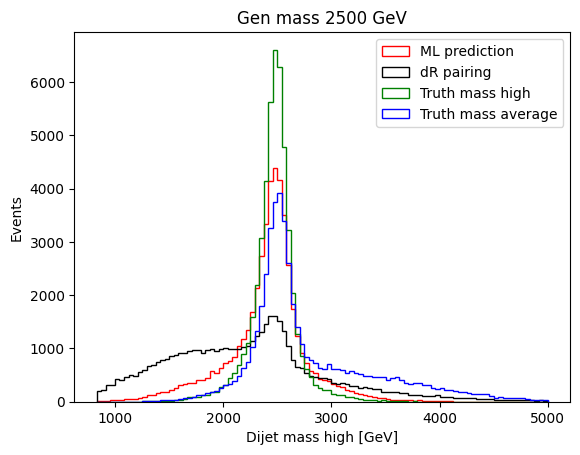

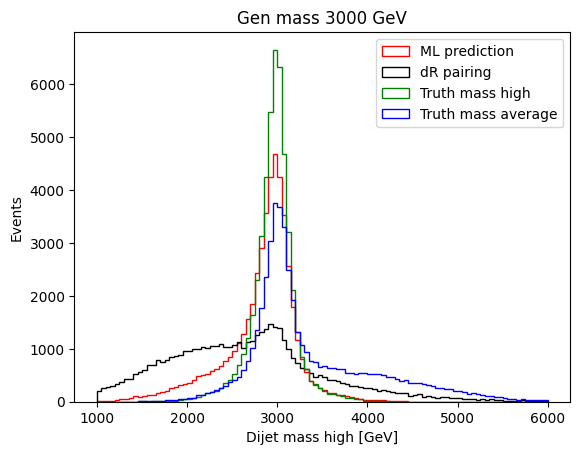

In [36]:
# for each gen mass sample, plot dijet mass high
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_M_high"], bins = 100, range = [Mass/3, Mass*2],
             histtype = "step", color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_M_high"], bins = 100, range = [Mass/3, Mass*2],
             histtype = "step", color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_M_high"], bins = 100, range = [Mass/3, Mass*2],
             histtype = "step", color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_M_high"], bins = 100, range = [Mass/3, Mass*2],
             histtype = "step", color = "b", label = "Truth mass average")
    plt.legend(loc="upper right")
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("Dijet mass high [GeV]")
    plt.ylabel("Events")
    plt.savefig(ResultsDir + "Dijet_mass_high_" + str(Mass) + "GeV.png")

In [37]:
P1QSMDi = TestingDF.columns.get_loc("P1QSMD")
TestingDF["dR_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["dRi"]]
TestingDF["Truth_high_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Truth_high"]]
TestingDF["Truth_avg_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Truth_avg"]]
TestingDF["Pred_QSMD"] = TestingDF.to_numpy()[np.arange(len(TestingDF)), P1QSMDi + TestingDF["Pred"]]
TestingDF

,Mass,evt_trig,fourjetmasstev,Mjj_avg_dRpairing_GeV,P1high_MTeV,P1low_MTeV,P2high_MTeV,P2low_MTeV,P3high_MTeV,P3low_MTeV,P1high_dR,P1low_dR,P2high_dR,P2low_dR,P3high_dR,P3low_dR,P1high_M,P1low_M,P2high_M,P2low_M,P3high_M,P3low_M,P1M,P2M,P3M,dRi,Truth_high,Truth_avg,P1QSMD,P2QSMD,P3QSMD,Truth_QSMD,Pred,dR_M,Truth_high_M,Truth_avg_M,Pred_M,dR_M_high,Truth_high_M_high,Truth_avg_M_high,Pred_M_high,dR_QSMD,Truth_high_QSMD,Truth_avg_QSMD,Pred_QSMD
0,500,1,1.665246,569.138611,1.083193,0.373950,0.676399,0.612059,0.610390,0.527888,2.782113,1.547665,1.907177,2.159548,2.022496,1.730264,1083.193410,373.949755,676.398680,612.058930,610.389668,527.887546,728.571582,644.228805,569.138607,2,2,2,3.560032e+05,4.367370e+04,1.296359e+04,2,1,569.138607,569.138607,569.138607,644.228805,610.389668,610.389668,610.389668,676.398680,1.296359e+04,1.296359e+04,1.296359e+04,4.367370e+04
1,500,1,1.109070,235.760468,0.703446,0.375377,0.497867,0.468088,0.342566,0.128955,3.113047,2.368026,2.692501,1.955640,1.254488,0.457324,703.445644,375.376717,497.867207,468.088484,342.566192,128.954730,539.411181,482.977846,235.760461,2,1,1,5.692109e+04,1.022894e+03,1.624600e+05,1,1,235.760461,482.977846,482.977846,482.977846,342.566192,497.867207,497.867207,497.867207,1.624600e+05,1.022894e+03,1.022894e+03,1.022894e+03
2,500,1,1.522245,473.871796,0.884906,0.596236,0.743461,0.438657,0.513220,0.434524,3.090241,3.215255,2.348969,1.981968,1.479761,1.521776,884.905691,596.236004,743.460797,438.656782,513.219915,434.523672,740.570848,591.058789,473.871794,2,2,2,1.574138e+05,6.303615e+04,4.461916e+03,2,2,473.871794,473.871794,473.871794,473.871794,513.219915,513.219915,513.219915,513.219915,4.461916e+03,4.461916e+03,4.461916e+03,4.461916e+03
3,500,1,2.525532,472.603851,2.169740,0.265412,0.801181,0.651792,0.703891,0.241316,2.993525,2.251249,2.862716,2.342220,1.928741,0.635207,2169.740485,265.412339,801.180826,651.791965,703.891486,241.316244,1217.576412,726.486396,472.603865,2,2,2,2.843065e+06,1.137507e+05,1.084890e+05,2,1,472.603865,472.603865,472.603865,726.486396,703.891486,703.891486,703.891486,801.180826,1.084890e+05,1.084890e+05,1.084890e+05,1.137507e+05
4,500,1,1.569428,567.971130,0.936199,0.199743,0.899177,0.482994,0.512215,0.500105,2.279822,0.934763,2.700373,2.369658,1.880583,1.437924,936.198882,199.743343,899.176959,482.993652,512.215294,500.104844,567.971112,691.085306,506.160069,0,2,2,2.804235e+05,1.596315e+05,1.492244e+02,2,2,567.971112,506.160069,506.160069,506.160069,936.198882,512.215294,512.215294,512.215294,2.804235e+05,1.492244e+02,1.492244e+02,1.492244e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,3000,1,6.142254,2605.686768,3.726679,2.139488,2.616437,2.594937,2.142181,1.065793,3.557276,3.214979,2.495388,3.063509,2.823131,2.938442,3726.679280,2139.487545,2616.436654,2594.936898,2142.180822,1065.792656,2933.083412,2605.686776,1603.986739,1,1,0,1.268544e+06,3.111970e+05,4.477012e+06,1,1,2605.686776,2605.686776,2933.083412,2605.686776,2616.436654,2616.436654,3726.679280,2616.436654,3.111970e+05,3.111970e+05,1.268544e+06,3.111970e+05
599996,3000,1,5.129152,1248.353516,2.798038,1.912490,2.437130,2.124802,2.054564,0.442143,3.294043,2.397300,2.841346,3.037939,1.969007,0.621246,2798.037987,1912.490264,2437.130249,2124.802439,2054.564499,442.142653,2355.264125,2280.966344,1248.353576,2,0,0,1.223466e+06,1.082793e+06,7.436482e+06,1,1,1248.353576,2355.264125,2355.264125,2280.966344,2054.564499,2798.037987,2798.037987,2437.130249,7.436482e+06,1.223466e+06,1.223466e+06,1.082793e+06
599997,3000,1,6.280539,1231.659424,4.524592,1.535514,3.297457,1.661724,1.345551,1.117768,4.409254,3.134380,3.414219,3.425090,1.548936,1.288221,4524.592364,1535.514102,3297.457153,1661.724282,1345.551306,1117.767633,3030.053233,2479.590718,1231.659470,2,1,0,4.469101e+06,1.879463e+06,6.279999e+06,1,2,1231.659470,2479.590718,3030.053233,1231.659470,1345

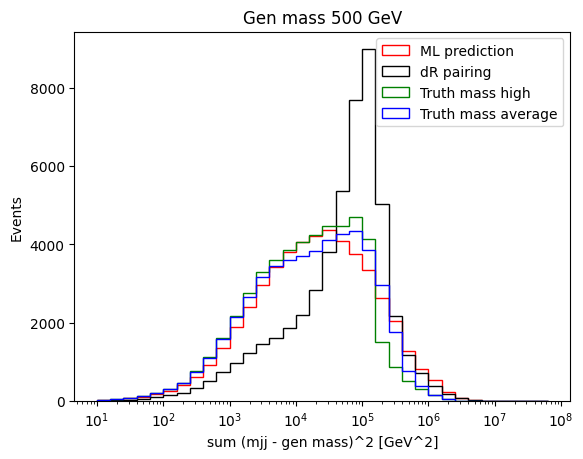

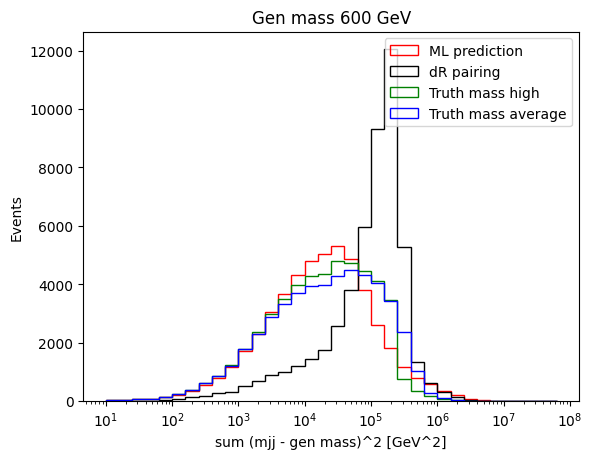

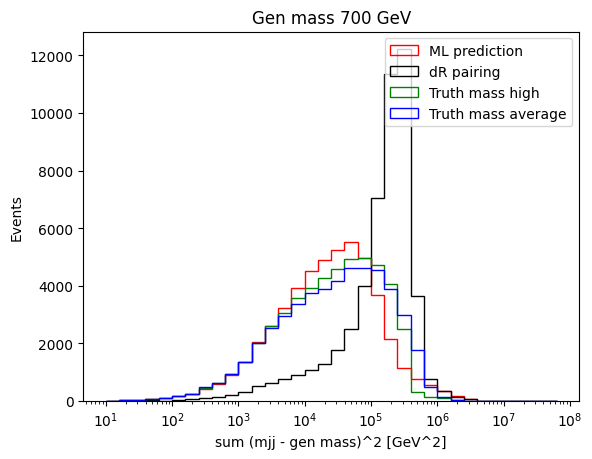

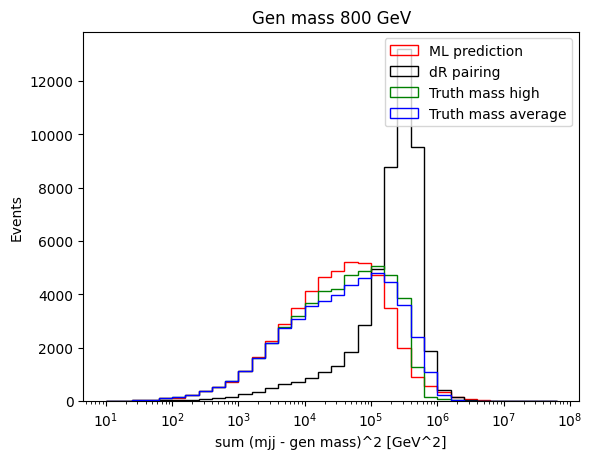

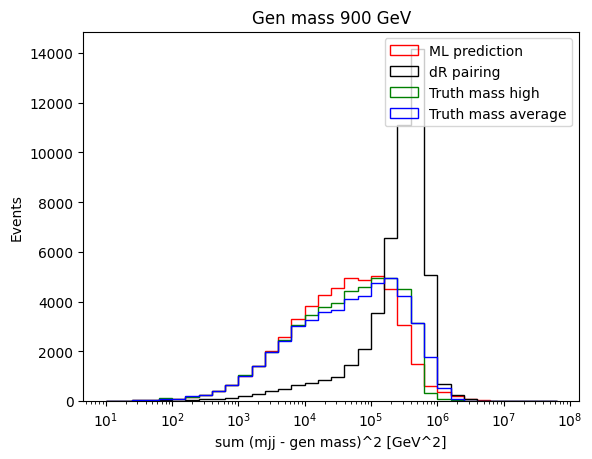

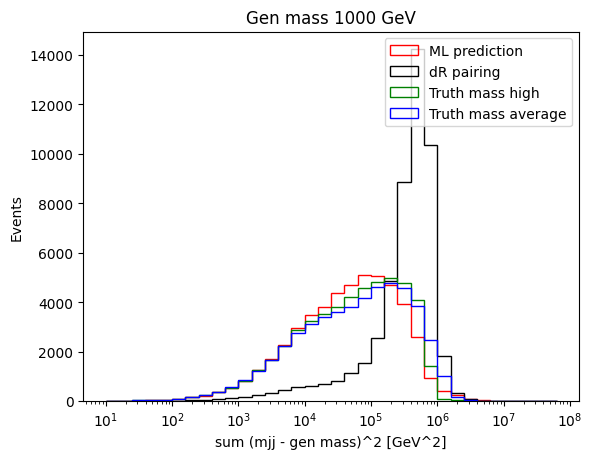

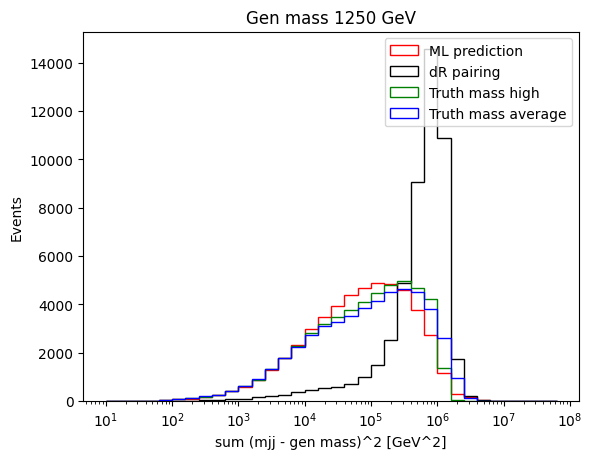

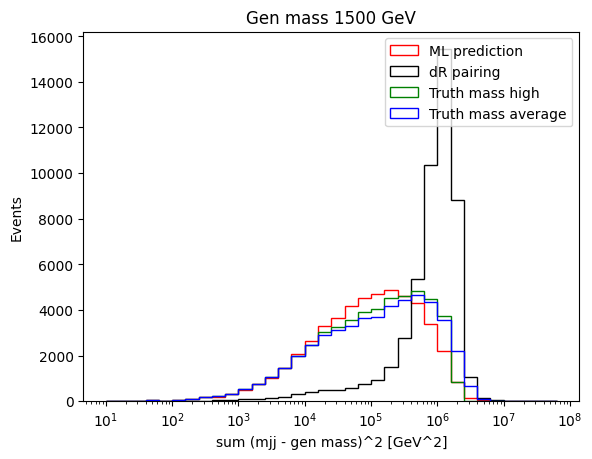

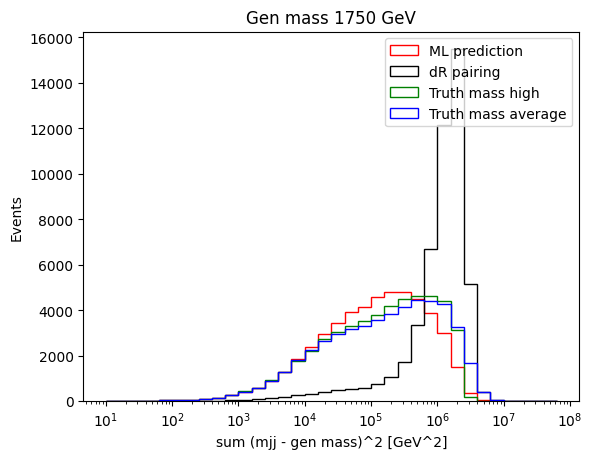

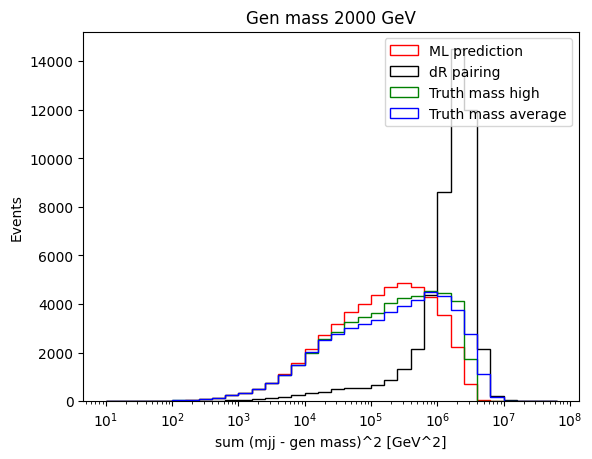

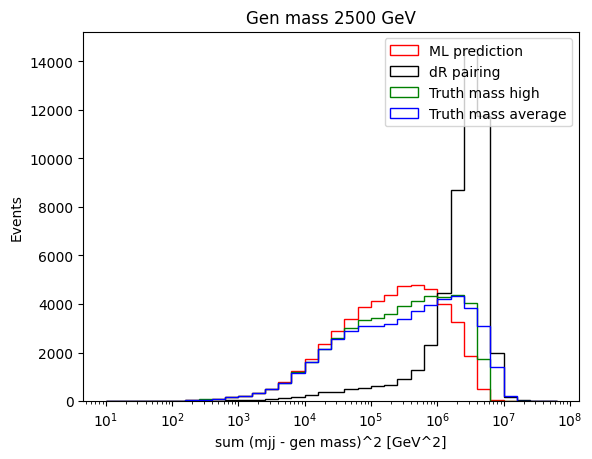

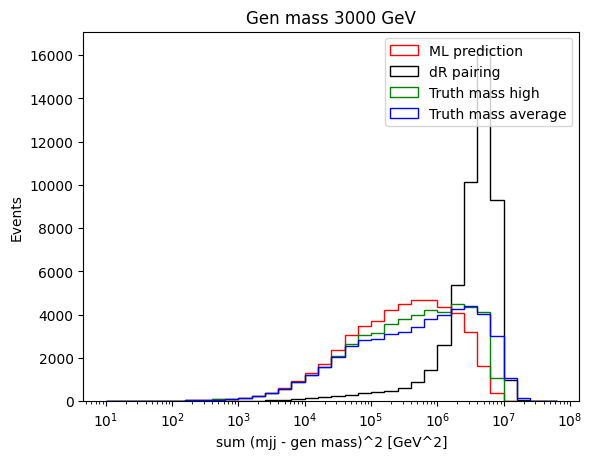

In [38]:
# for each gen mass sample, plot sum (mjj - gen mass)^2
for Mass in Masses:
    TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
    Bins = [10**(x/5) for x in range(5,40)]
    plt.figure()
    plt.hist(TestingDF_temp["Pred_QSMD"], bins = Bins,
             histtype = "step", color = "r", label = "ML prediction")
    plt.hist(TestingDF_temp["dR_QSMD"], bins = Bins,
             histtype = "step", color = "k", label = "dR pairing")
    plt.hist(TestingDF_temp["Truth_high_QSMD"], bins = Bins,
             histtype = "step", color = "g", label = "Truth mass high")
    plt.hist(TestingDF_temp["Truth_avg_QSMD"], bins = Bins,
             histtype = "step", color = "b", label = "Truth mass average")
    plt.xscale('log')
    plt.legend()
    plt.title("Gen mass " + str(Mass) + " GeV")
    plt.xlabel("sum (mjj - gen mass)^2 [GeV^2]")
    plt.ylabel("Events")
    plt.savefig(ResultsDir + "Quad_sum_mass_diff_" + str(Mass) + "GeV.png")

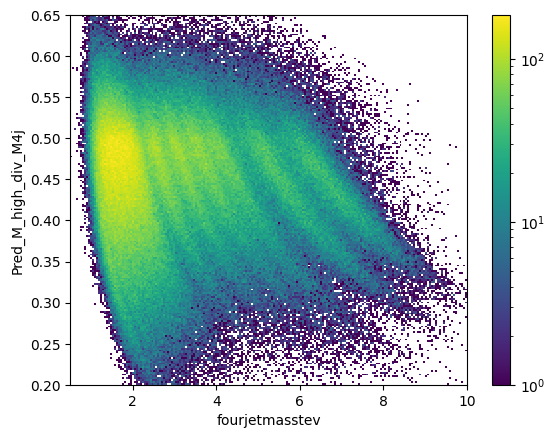

In [39]:
TestingDF["Pred_M_high_div_M4j"] = TestingDF["Pred_M_high"] / 1000 / TestingDF["fourjetmasstev"]
if SanityCheckPlots:
    plt.hist2d(TestingDF["fourjetmasstev"], TestingDF["Pred_M_high_div_M4j"],
               bins = 200, range = [[0.5,10], [0.2,0.65]], norm = "log")
    plt.xlabel("fourjetmasstev")
    plt.ylabel("Pred_M_high_div_M4j")
    plt.colorbar()
    plt.savefig(ResultsDir + "Pred_M_high_div_M4j_vs_M4j.png")

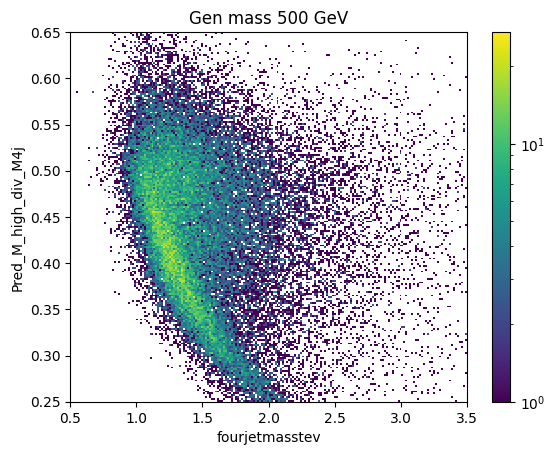

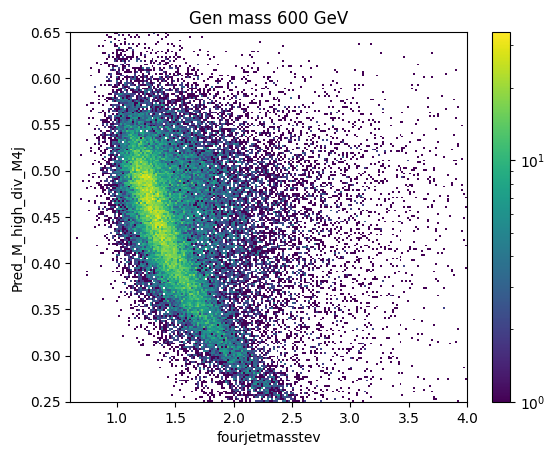

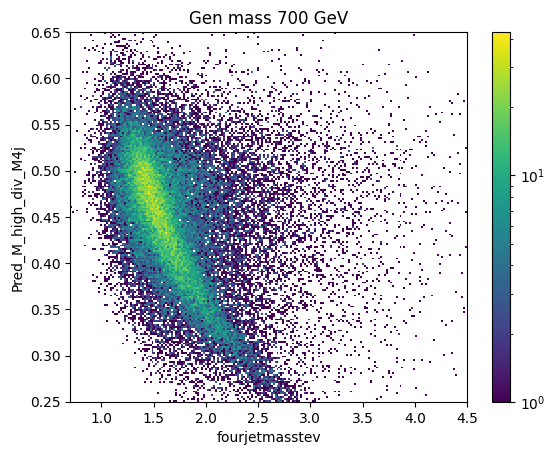

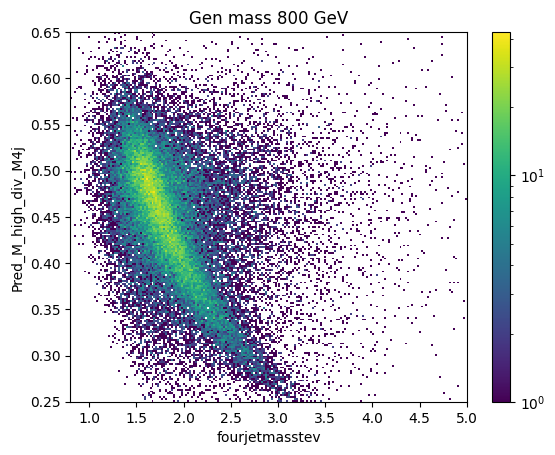

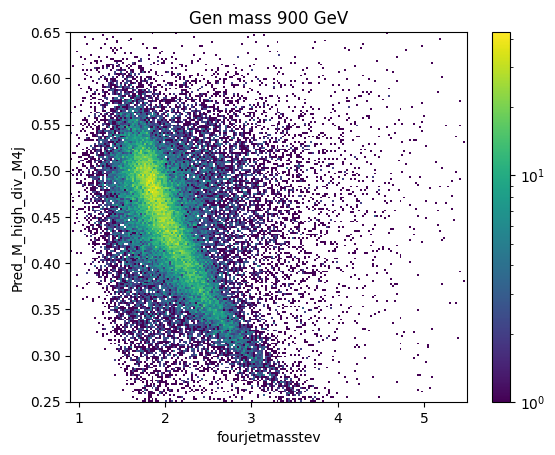

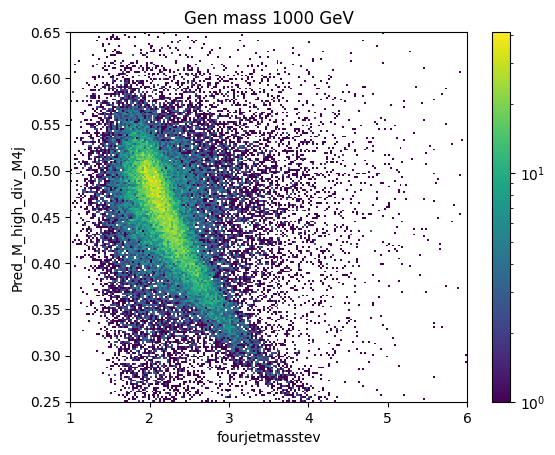

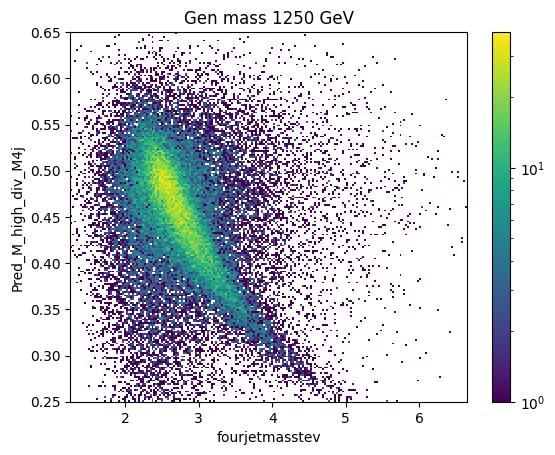

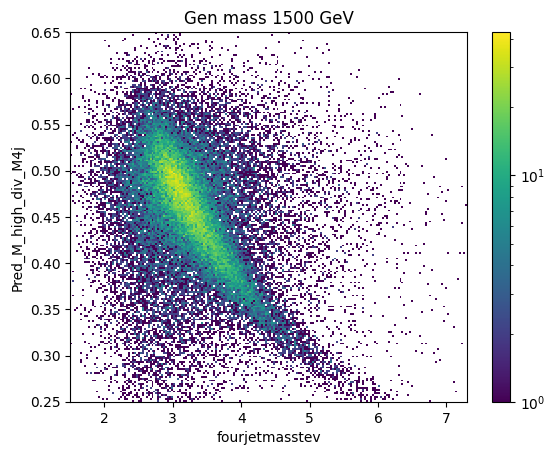

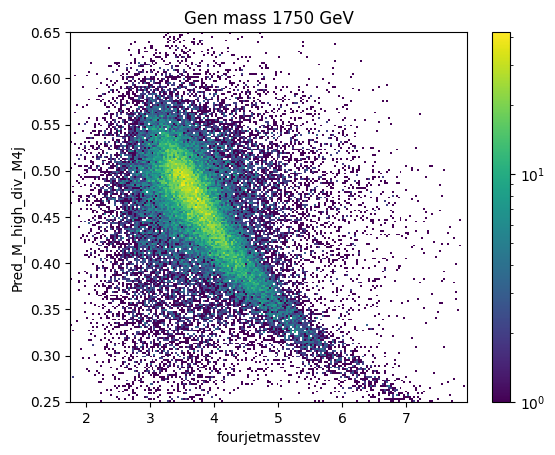

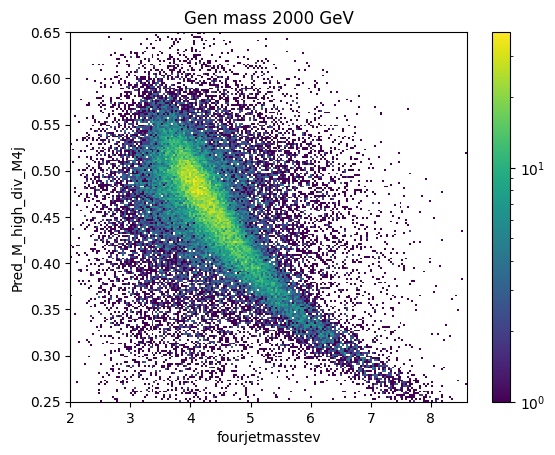

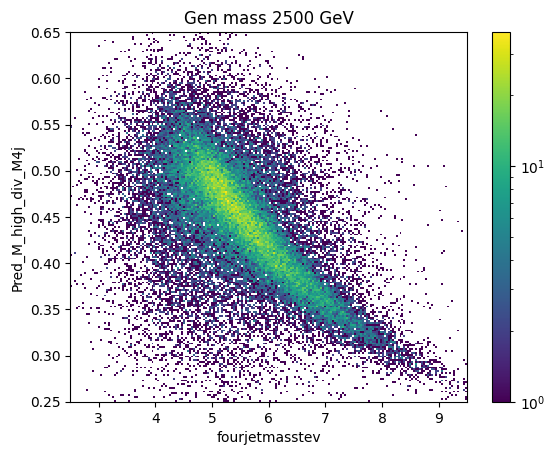

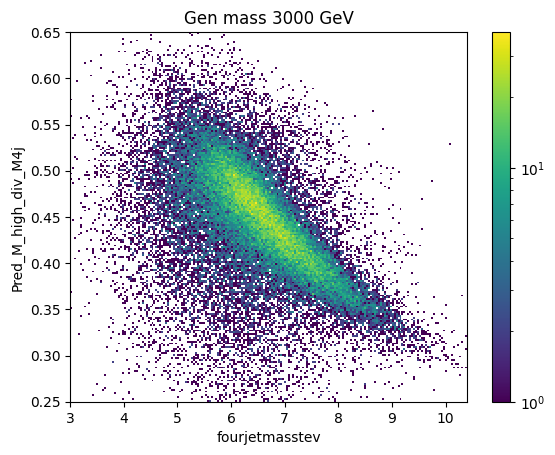

In [40]:
if SanityCheckPlots:
    for i, Mass in enumerate(Masses):
        TestingDF_temp = TestingDF.loc[TestingDF["Mass"] == Mass]
        if len(TestingDF_temp.index) == 0: continue
        
        plt.figure()    
        plt.hist2d(TestingDF_temp["fourjetmasstev"], TestingDF_temp["Pred_M_high_div_M4j"],
                   bins = 200, range = [[Mass/1000.0, Mass/1000.0 + 3 + 0.4*i], [0.25,0.65]], norm = "log")
        plt.title("Gen mass " + str(Mass) + " GeV")
        plt.xlabel("fourjetmasstev")
        plt.ylabel("Pred_M_high_div_M4j")
        plt.colorbar()
        plt.savefig(ResultsDir + "Pred_M_high_div_M4j_vs_M4j_" + str(Mass) + "GeV.png")